# Experiments for asynchronous gate and expert training with different datasets

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

device cuda:0
device cuda:0
device cuda:0
device cuda:0


In [6]:
no_gate_temps = np.concatenate((np.asarray([1e-4,1e-3,1e-2]), np.arange(0.2,1.0,0.2), np.arange(1.0,1.55,0.1)))
no_gate_temps

array([1.0e-04, 1.0e-03, 1.0e-02, 2.0e-01, 4.0e-01, 6.0e-01, 8.0e-01,
       1.0e+00, 1.1e+00, 1.2e+00, 1.3e+00, 1.4e+00, 1.5e+00])

### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [7]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/test'
model_path = '../models/test'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [8]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]) 

In [9]:
trainsize = 10000
testsize = 2000

In [10]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=mnist_transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=mnist_transform,
    target_transform = torch.tensor,)

batch_size = 64
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


Data samples


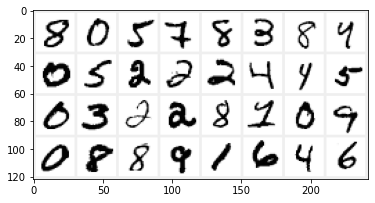

In [11]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


### Create combined rotated and unrotated MNIST image dataset of the digits 1-5

In [12]:
from PIL import Image
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 1, 28,28)
    tensor = transforms.ToTensor()
    norm = transforms.Normalize((0.1307,), (0.3081,))
    
    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = norm(TF.rotate(tensor(img), rotation))
    return result

In [13]:
rot = 90

rot_train = rotate_dataset(trainset.data, rot)
rot_test= rotate_dataset(testset.data, rot)

In [14]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, targets):
    print(classes_sub)
    start = 0
    labels = targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [15]:
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

In [16]:
mnist_indices_train = filter_classes(classes_mnist[0:5], classes_mnist, int(trainsize/2), trainset.targets)
mnist_indices_test = filter_classes(classes_mnist[0:5], classes_mnist, int(testsize/2), testset.targets)

['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']


In [17]:
# shifting the labels by 5 to avoid overlap when selecting digits 1-5
classes_rot_mnist = ['5','6','7','8','9','10','11','12','13','14']

In [18]:
rot_trainset = TensorDataset(rot_train, trainset.targets+5)
rot_testset = TensorDataset(rot_test, testset.targets+5)

In [19]:
rot_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_train), batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_test), batch_size=len(mnist_indices_test),
                                         shuffle=True, num_workers=1, pin_memory=True)

Data samples


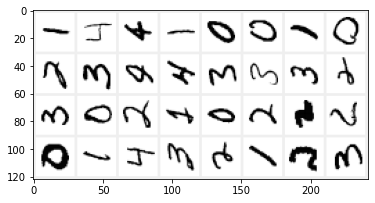

In [20]:
# create grid of images
dataiter = iter(rot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


In [21]:
rot_unrot_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(trainset,mnist_indices_train), 
                                                 torch.utils.data.Subset(rot_trainset,mnist_indices_train)])
rot_unrot_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(testset,mnist_indices_test),
                                                torch.utils.data.Subset(rot_testset,mnist_indices_test)])

In [22]:
rot_unrot_trainloader = torch.utils.data.DataLoader(rot_unrot_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_unrot_testloader = torch.utils.data.DataLoader(rot_unrot_testset, batch_size=len(rot_unrot_testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

Data samples


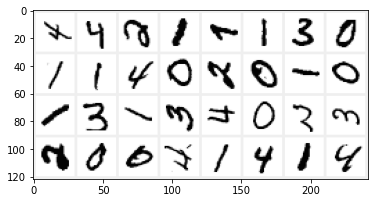

In [23]:
# create grid of images
dataiter = iter(rot_unrot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Create combined FMNIST and MNIST dataset

In [24]:
# transforms: Convert PIL image to tensors and normalize
fmnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.2859,), (0.3530,))]) 

In [25]:
fmnist_trainset = torchvision.datasets.FashionMNIST('data', transform=fmnist_transform, train=True, download=True)

In [26]:
fmnist_testset = torchvision.datasets.FashionMNIST('data',transform=fmnist_transform, train=False)

In [27]:
# Since we are combining the fashion mnist and mnist data that have the same numerical labels from 0-9 
# we want to offset the mnist target so there is no overlap of the labels
def target_transform(target):
    return target+2

In [28]:
mnist_trainset = torchvision.datasets.MNIST('data', transform=mnist_transform, target_transform=target_transform, train=True, download=True)

In [29]:
mnist_testset = torchvision.datasets.MNIST('data',transform=mnist_transform, target_transform=target_transform, train=False)

In [30]:
classes_fmnist = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
                  'Shirt','Sneaker','Bag','Ankle boot']
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

# Combined fmnist and mnist classes. 
classes_fmnist_mnist = classes_fmnist[0:6]+[str(n) for n in range(4,10)]
print('classes_fmnist_mnist', classes_fmnist_mnist)

classes_fmnist_mnist ['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', '4', '5', '6', '7', '8', '9']


In [31]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, data):
    print(classes_sub)
    start = 0
    labels = data.targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [32]:
# Get the data for first 6 classes of fmnist dataset
fmnist_indices_train = filter_classes(classes_fmnist[0:6], classes_fmnist, int(trainsize/2), fmnist_trainset)
fmnist_indices_test = filter_classes(classes_fmnist[0:6], classes_fmnist, int(testsize/2), fmnist_testset)

['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']
['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']


In [33]:
fmnist_trainset.targets[fmnist_indices_train]

tensor([0, 0, 0,  ..., 5, 5, 5])

In [34]:
# Get the data for last 6 classes of fmnist dataset
mnist_indices_train = filter_classes(classes_mnist[4:], classes_mnist, int(trainsize/2), mnist_trainset)
mnist_indices_test = filter_classes(classes_mnist[4:], classes_mnist, int(testsize/2), mnist_testset)

['4', '5', '6', '7', '8', '9']
['4', '5', '6', '7', '8', '9']


In [35]:
# Create the combined dataset with fmnist and mnist classes
fmnist_mnist_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_trainset,fmnist_indices_train), 
                         torch.utils.data.Subset(mnist_trainset,mnist_indices_train)])
fmnist_mnist_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_testset,fmnist_indices_test), 
                        torch.utils.data.Subset(mnist_testset,mnist_indices_test)])
train_size = len(fmnist_indices_train)+len(mnist_indices_train)
test_size = len(fmnist_indices_test)+len(mnist_indices_test)
print("Train size", train_size)
print("Test size", test_size)

Train size 10000
Test size 2000


In [36]:
fmnist_mnist_trainloader = torch.utils.data.DataLoader(fmnist_mnist_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
fmnist_mnist_testloader = torch.utils.data.DataLoader(fmnist_mnist_testset, batch_size=len(fmnist_mnist_testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

In [37]:
num_classes_fmnist_mnist = len(classes_fmnist_mnist)

Data samples


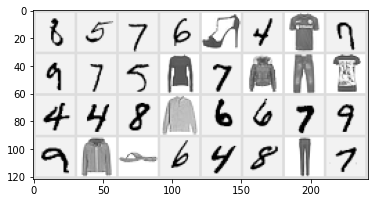

In [38]:
# create grid of images
dataiter = iter(fmnist_mnist_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Create imbalanced MNIST trainset

In [39]:
def imbalance_dataset(labels, fracs, selected_labels, size):
    
    unique_labels = torch.unique(labels)
    per_class_size = ceil(size/len(unique_labels))
    all_indices = []
    for l in unique_labels:
        indices = torch.where(labels == l)[0][0:per_class_size]
        if l in selected_labels:
            frac = fracs[np.random.randint(0,len(fracs),1)[0]]
        else:
            frac = 1.0
        selected_indices = list(np.random.choice(indices, int(frac*len(indices))))
        all_indices = all_indices + selected_indices
    return all_indices



In [40]:
# fracs = [0.25,0.5,0.75, 1.0]
# fracs = [0.3]

# imbalanced_indices = imbalance_dataset(trainset.targets, fracs, [0,1,2,3,4,6,7,8,9], trainsize*3) 

# imbalanced_trainset = torch.utils.data.Subset(trainset,imbalanced_indices)

# torch.save(imbalanced_trainset, open('data/imbalanced_dataset_5.data', 'wb'))

In [41]:
imbalanced_trainset = torch.load(open('data/imbalanced_dataset_5.data', 'rb'))

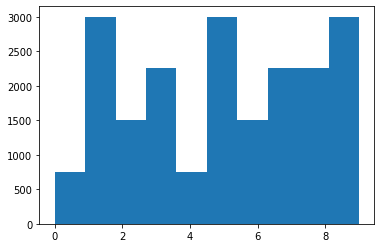

In [42]:
imbalanced_trainloader_all = torch.utils.data.DataLoader(imbalanced_trainset, 
                                                         batch_size=len(imbalanced_trainset),
                                                         shuffle=True, num_workers=1, pin_memory=True)
for _, labels in imbalanced_trainloader_all:
    plt.hist(labels.numpy(), align='mid')

In [43]:
imbalanced_trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=64,
                                          shuffle=True, num_workers=1, pin_memory=True)

Data samples


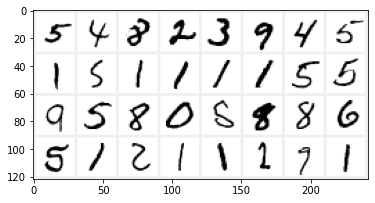

In [44]:
# create grid of images
dataiter = iter(imbalanced_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Define expert and gate networks

In [45]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=64) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=64, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [46]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [47]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

In [48]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class single_model(nn.Module):
    def __init__(self, num_classes=10):
        super(single_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=64) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=64, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        return t

## Initialize configurations and helper functions

In [49]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Funtion to train MoR in: 
### (1) dual temp mode where experts and gates are trained with different temperatures
### (2) with regularization
### (3) dual temp and regularization
### (4) without regularization when w_importance = 0.
### (5) training the whole model end-to-end when T = 0.

### NOTE: when importance is set to 0 then it is the default training without regularization

In [59]:
from itertools import product

def train_dual_temp_regularization_model(model_1, trainloader, testloader, runs, temps=[1.0]*20, 
                                         w_importance_range=[0.0], w_sample_sim_same_range=[0.0], 
                                         w_sample_sim_diff_range=[0.0], w_exp_gamma_range=[0.0],
                                         num_classes=10, total_experts=5, num_epochs=20):

    for T, w_importance, w_sample_sim_same, w_sample_sim_diff, w_exp_gamma in product(temps, w_importance_range, w_sample_sim_same_range,  w_sample_sim_diff_range, 
                                                                       w_exp_gamma_range):
        
        print('Temperature',['{:.1f}'.format(t) for t in T])
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))

        if w_exp_gamma < 1:
            print('w_exp_gamma',str(w_exp_gamma))
        else:
            print('w_exp_gamma','{:.1f}'.format(w_exp_gamma))

        n_run_models_1 = []
        for run in range(runs):

            print('Run:', run), 

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes).to(device)

                gate_model = gate_layers(total_experts).to(device)

                moe_model = val['model'](total_experts, num_classes,
                                         experts=expert_models, gate=gate_model).to(device)

                optimizer_experts = optim.Adam(expert_models.parameters(), lr=0.001, amsgrad=False)

                optimizer_gate = optim.Adam(gate_model.parameters(), lr=0.001, amsgrad=False)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       optimizer_experts = optimizer_experts, optimizer_gate=optimizer_gate, 
                                       T = T, w_importance=w_importance, w_sample_sim_same = w_sample_sim_same, w_sample_sim_diff = w_sample_sim_diff, 
                                       w_exp_gamma=w_exp_gamma,
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            n_run_models_1.append(models)

        # Save all the trained models
        plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                       specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))


In [60]:
def train_single_model(model_name, trainloader, testloader, num_classes, num_epochs, runs):
    
    loss_criterion = cross_entropy_loss()
    
    n_runs = {'models':[], 'history':[]}
    
    for i in range(runs):
        
        print('Run', i)
        
        model = single_model(num_classes).to(device)
        history = {'loss':[], 'accuracy':[], 'val_accuracy':[]}
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0

            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)

                optimizer.zero_grad()
                loss = loss_criterion(outputs, labels)

                loss.backward()

                optimizer.step()

                running_loss += loss.item()

                outputs = model(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            for test_inputs, test_labels in testloader:
                test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)
                test_outputs = model(test_inputs)
                test_accuracy = accuracy(test_outputs, test_labels)
                
            running_loss = (running_loss/num_batches)
            train_running_accuracy = (train_running_accuracy/num_batches)
            
            history['loss'].append(running_loss)
            history['accuracy'].append(train_running_accuracy)
            history['val_accuracy'].append(test_accuracy.item())
            
            print('epoch %d' % epoch,
                  'training loss %.2f' % running_loss,
                   ', training accuracy %.2f' % train_running_accuracy,
                   ', test accuracy %.2f' % test_accuracy
                   )
        n_runs['models'].append(model)
        n_runs['history'].append(history)
            
    plot_file = generate_plot_file(model_name, specific=str(num_classes)+'_models.pt')
    torch.save(n_runs, open(os.path.join(model_path, plot_file),'wb'))

## Experiment 1: MoE model training with dual temperature

### MNIST data

In [52]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_dual_temp_hidden_32'

In [53]:
total_experts = 5

In [54]:
num_epochs = 20

In [55]:
temps = [[T]* num_epochs for T in np.arange(1.1,1.6,0.1)]
temps += [[T]* num_epochs for T in np.arange(2,11,2)]
# temps += [[T]* num_epochs for T in np.arange(25,51,5)]
# temps = [[20]*num_epochs]
np.unique(temps)

array([ 1.1,  1.2,  1.3,  1.4,  1.5,  2. ,  4. ,  6. ,  8. , 10. ])

In [56]:
runs = 10

In [57]:
train_dual_temp_regularization_model(model_1, trainloader, testloader, runs, temps, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.94 , training accuracy 0.75 , test accuracy 0.86
epoch 1 training loss 0.32 , training accuracy 0.91 , test accuracy 0.89
epoch 2 training loss 0.25 , training accuracy 0.93 , test accuracy 0.90
epoch 3 training loss 0.21 , training accuracy 0.94 , test accuracy 0.91
epoch 4 training loss 0.18 , training accuracy 0.95 , test accuracy 0.91
epoch 5 training loss 0.15 , training accuracy 0.96 , test accuracy 0.92
epoch 6 training loss 0.13 , training accuracy 0.96 , test accuracy 0.92
epoch 7 training loss 0.11 , training accuracy 0.97 , test accuracy 0.93
epoch 8 training loss 0.10 , training accuracy 0.97 , test accuracy 0.93
epoch 9 training loss 0.09 , training accuracy 0.98 , test accuracy 0.93
epoch 10 training los

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps

In [ ]:
w_importance_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

### Combined rotated and unrotated MNIST data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'rot_mnist_dual_temp'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps

In [ ]:
w_importance_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, rot_unrot_trainloader, rot_unrot_testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

### Combined FMNIST MNIST data

In [106]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_dual_temp'

In [107]:
total_experts = 6

In [108]:
num_epochs = 20

In [109]:
temps = [[T]* num_epochs for T in np.arange(1.1,1.6,0.1)]
temps += [[T]* num_epochs for T in np.arange(2,21,2)]
# temps += [[T]* num_epochs for T in np.arange(25,51,5)]
temps = [[20]*num_epochs]
np.unique(temps)

array([20])

In [110]:
runs = 1

In [112]:
train_dual_temp_regularization_model(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, 
                                      runs, temps, num_classes=num_classes_fmnist_mnist, 
                                      total_experts=total_experts, num_epochs=num_epochs)

Temperature ['20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0', '20.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 2.07 , training accuracy 0.30 , test accuracy 0.47
epoch 1 training loss 0.84 , training accuracy 0.72 , test accuracy 0.73
epoch 2 training loss 0.57 , training accuracy 0.82 , test accuracy 0.81
epoch 3 training loss 0.48 , training accuracy 0.85 , test accuracy 0.83
epoch 4 training loss 0.42 , training accuracy 0.86 , test accuracy 0.82
epoch 5 training loss 0.40 , training accuracy 0.87 , test accuracy 0.84
epoch 6 training loss 0.37 , training accuracy 0.88 , test accuracy 0.85
epoch 7 training loss 0.35 , training accuracy 0.88 , test accuracy 0.86
epoch 8 training loss 0.33 , training accuracy 0.89 , test accuracy 0.86
epoch 9 training loss 0.32 , training accuracy 0.90 , test accuracy 0.86
epoch 10 training loss 0.31 

### MNIST imbalanced data

## Experiment 2: MoE model training with gate regularization

### MNIST data

In [53]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_with_reg_hidden_32'

In [54]:
total_experts = 5

In [55]:
num_epochs = 20

In [56]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [57]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [58]:
runs = 10

In [61]:
train_dual_temp_regularization_model(model_2, trainloader, testloader, runs, temps, w_importance_range=w_importance_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.10 , training accuracy 0.70 , test accuracy 0.85
epoch 1 training loss 0.39 , training accuracy 0.90 , test accuracy 0.88
epoch 2 training loss 0.30 , training accuracy 0.93 , test accuracy 0.89
epoch 3 training loss 0.24 , training accuracy 0.94 , test accuracy 0.90
epoch 4 training loss 0.21 , training accuracy 0.95 , test accuracy 0.92
epoch 5 training loss 0.17 , training accuracy 0.96 , test accuracy 0.91
epoch 6 training loss 0.16 , training accuracy 0.96 , test accuracy 0.92
epoch 7 training loss 0.14 , training accuracy 0.97 , test accuracy 0.92
epoch 8 training loss 0.12 , training accuracy 0.97 , test accuracy 0.93
epoch 9 training loss 0.11 , training accuracy 0.98 , test accuracy 0.93
epoch 10 training los

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_imbalanced_5_with_regularization'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = [1.0]

In [ ]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range 

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_2, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

### Combined rotated and unrotated MNIST data

In [75]:
# Model with gate and expert parameters initialized to default values
model_2 = 'rot_mnist_with_reg_hidden_32'

In [76]:
total_experts = 5

In [77]:
num_epochs = 20

In [78]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [79]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [80]:
runs = 10

In [81]:
train_dual_temp_regularization_model(model_2, rot_unrot_trainloader, rot_unrot_testloader, runs, temps=temps, w_importance_range=w_importance_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.88 , training accuracy 0.79 , test accuracy 0.92
epoch 1 training loss 0.25 , training accuracy 0.94 , test accuracy 0.94
epoch 2 training loss 0.21 , training accuracy 0.95 , test accuracy 0.95
epoch 3 training loss 0.18 , training accuracy 0.96 , test accuracy 0.96
epoch 4 training loss 0.16 , training accuracy 0.97 , test accuracy 0.95
epoch 5 training loss 0.14 , training accuracy 0.97 , test accuracy 0.95
epoch 6 training loss 0.13 , training accuracy 0.98 , test accuracy 0.95
epoch 7 training loss 0.11 , training accuracy 0.98 , test accuracy 0.96
epoch 8 training loss 0.10 , training accuracy 0.98 , test accuracy 0.95
epoch 9 training loss 0.09 , training accuracy 0.99 , test accuracy 0.95
epoch 10 training loss 0.09 , tra

### Combined FMNIST MNIST data

In [82]:
# Model with gate and expert parameters initialized to default values
model_2 = 'fmnist_mnist_with_reg_hidden_32'

In [83]:
total_experts = 6

In [84]:
num_epochs = 20

In [85]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [86]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [87]:
runs = 10

In [88]:
train_dual_temp_regularization_model(model_2, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, temps=temps, w_importance_range=w_importance_range, num_classes=num_classes_fmnist_mnist, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.09 , training accuracy 0.72 , test accuracy 0.84
epoch 1 training loss 0.38 , training accuracy 0.89 , test accuracy 0.88
epoch 2 training loss 0.30 , training accuracy 0.92 , test accuracy 0.89
epoch 3 training loss 0.26 , training accuracy 0.93 , test accuracy 0.90
epoch 4 training loss 0.23 , training accuracy 0.93 , test accuracy 0.90
epoch 5 training loss 0.21 , training accuracy 0.94 , test accuracy 0.91
epoch 6 training loss 0.19 , training accuracy 0.95 , test accuracy 0.90
epoch 7 training loss 0.18 , training accuracy 0.95 , test accuracy 0.91
epoch 8 training loss 0.17 , training accuracy 0.96 , test accuracy 0.91
epoch 9 training loss 0.16 , training accuracy 0.96 , test accuracy 0.91
epoch 10 training loss 0.14 , tra

## Experiment 3: MoE model training without gate regularization

### MNIST data

In [62]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_without_reg_hidden_32'

In [63]:
total_experts = 5

In [64]:
num_epochs = 20

In [65]:
temps = [[1.0]*num_epochs]

In [66]:
runs = 10

In [67]:
train_dual_temp_regularization_model(model_3, trainloader, testloader, runs, temps, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.92 , training accuracy 0.75 , test accuracy 0.86
epoch 1 training loss 0.32 , training accuracy 0.91 , test accuracy 0.88
epoch 2 training loss 0.26 , training accuracy 0.93 , test accuracy 0.89
epoch 3 training loss 0.22 , training accuracy 0.94 , test accuracy 0.91
epoch 4 training loss 0.19 , training accuracy 0.95 , test accuracy 0.91
epoch 5 training loss 0.16 , training accuracy 0.95 , test accuracy 0.92
epoch 6 training loss 0.15 , training accuracy 0.96 , test accuracy 0.92
epoch 7 training loss 0.14 , training accuracy 0.96 , test accuracy 0.92
epoch 8 training loss 0.12 , training accuracy 0.97 , test accuracy 0.93
epoch 9 training loss 0.11 , training accuracy 0.97 , test accuracy 0.93
epoch 10 training los

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_imbalanced_5_without_regularization'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = [1.0]

In [ ]:
w_importance_range = [0]
w_importance_range

In [ ]:
w_ortho_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_3, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

### Combined rotated and unrotated MNIST data

In [89]:
# Model with gate and expert parameters initialized to default values
model_3 = 'rot_mnist_without_reg_hidden_32'

In [90]:
total_experts = 5

In [91]:
num_epochs = 20

In [92]:
temps = [[1.0]*num_epochs]

In [93]:
w_importance_range = [0]
w_importance_range

[0]

In [94]:
runs = 10

In [95]:
train_dual_temp_regularization_model(model_3, rot_unrot_trainloader, rot_unrot_testloader, runs, temps=temps, w_importance_range=w_importance_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.89 , training accuracy 0.75 , test accuracy 0.92
epoch 1 training loss 0.22 , training accuracy 0.94 , test accuracy 0.94
epoch 2 training loss 0.16 , training accuracy 0.96 , test accuracy 0.95
epoch 3 training loss 0.13 , training accuracy 0.96 , test accuracy 0.96
epoch 4 training loss 0.11 , training accuracy 0.97 , test accuracy 0.96
epoch 5 training loss 0.09 , training accuracy 0.98 , test accuracy 0.96
epoch 6 training loss 0.08 , training accuracy 0.98 , test accuracy 0.96
epoch 7 training loss 0.07 , training accuracy 0.98 , test accuracy 0.96
epoch 8 training loss 0.06 , training accuracy 0.98 , test accuracy 0.96
epoch 9 training loss 0.05 , training accuracy 0.99 , test accuracy 0.96
epoch 10 training loss 0.04 , tra

### Combined FMNIST MNIST data

In [96]:
# Model with gate and expert parameters initialized to default values
model_3 = 'fmnist_mnist_without_reg_hidden_32'

In [97]:
total_experts = 6

In [98]:
num_epochs = 20

In [99]:
w_importance_range = [0]
w_importance_range

[0]

In [100]:
runs = 10

In [102]:
train_dual_temp_regularization_model(model_3, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, temps=temps, w_importance_range=w_importance_range, num_classes=num_classes_fmnist_mnist, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.00 , training accuracy 0.74 , test accuracy 0.85
epoch 1 training loss 0.34 , training accuracy 0.89 , test accuracy 0.88
epoch 2 training loss 0.29 , training accuracy 0.91 , test accuracy 0.88
epoch 3 training loss 0.25 , training accuracy 0.92 , test accuracy 0.89
epoch 4 training loss 0.22 , training accuracy 0.92 , test accuracy 0.90
epoch 5 training loss 0.21 , training accuracy 0.93 , test accuracy 0.89
epoch 6 training loss 0.19 , training accuracy 0.94 , test accuracy 0.90
epoch 7 training loss 0.18 , training accuracy 0.94 , test accuracy 0.91
epoch 8 training loss 0.17 , training accuracy 0.95 , test accuracy 0.90
epoch 9 training loss 0.15 , training accuracy 0.95 , test accuracy 0.92
epoch 10 training loss 0.14 , tra

## Experiment 4: MoE model training with dual temp and gate regularization

### MNIST data

In [118]:
# Model with gate and expert parameters initialized to default values
model_4 = 'mnist_dual_temp_with_reg_hidden_32'

In [119]:
total_experts = 5

In [120]:
num_epochs = 20

In [121]:
temps = [[T]* num_epochs for T in np.arange(1.1,1.6,0.1)]
temps = [[1.5]*num_epochs]
temps += [[T]* num_epochs for T in np.arange(2,11,2)]
np.unique(temps)

array([ 1.5,  2. ,  4. ,  6. ,  8. , 10. ])

In [122]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [123]:
runs = 5

In [124]:
runs = 10

In [125]:
train_dual_temp_regularization_model(model_4, trainloader, testloader, runs, temps, 
                                     w_importance_range=w_importance_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5', '1.5']
w_importance 0.2
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.09 , training accuracy 0.74 , test accuracy 0.85
epoch 1 training loss 0.36 , training accuracy 0.91 , test accuracy 0.88
epoch 2 training loss 0.27 , training accuracy 0.93 , test accuracy 0.89
epoch 3 training loss 0.24 , training accuracy 0.94 , test accuracy 0.90
epoch 4 training loss 0.21 , training accuracy 0.94 , test accuracy 0.91
epoch 5 training loss 0.18 , training accuracy 0.95 , test accuracy 0.92
epoch 6 training loss 0.17 , training accuracy 0.96 , test accuracy 0.92
epoch 7 training loss 0.15 , training accuracy 0.96 , test accuracy 0.92
epoch 8 training loss 0.14 , training accuracy 0.96 , test accuracy 0.91
epoch 9 training loss 0.13 , training accuracy 0.97 , test accuracy 0.91
epoch 10 training los

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp_with_regularization'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
temps = [1.3]
w_importance_range = [0.8, 1.0]
print(temps)
print(w_importance_range)

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

## Experiment 5: MoE model training with dual temperature schedule

### MNIST data

In [168]:
# Model with gate and expert parameters initialized to default values
model_5 = 'mnist_dual_temp_on_schedule'

In [169]:
total_experts = 5

In [170]:
num_epochs = 20

In [171]:
temps =np.asarray([[1.2]*6+[1.1]*6+[1.0]*8])
temps =np.asarray([[20.0]*10+[10.0]*10+[1.0]*10])
temps = [list(np.arange(10,0,-2))+ [1.0]*15, 
         list(np.arange(20,10,-2))+ [1.0]*15]
          
#          list(np.arange(30,10,-2))+ [1.0]*15]
for i in range(len(temps)):
    print(temps[i], len(temps[i]))

[10, 8, 6, 4, 2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 20
[20, 18, 16, 14, 12, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 20


In [172]:
w_importance_range = [0.4,1.0]
w_importance_range

[0.4, 1.0]

In [173]:
runs = 10

In [174]:
train_dual_temp_regularization_model(model_5, trainloader, testloader, runs, temps, w_importance_range=w_importance_range,
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['10.0', '8.0', '6.0', '4.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.4
w_ortho 0.0
w_sample_sim 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 2.02 , training accuracy 0.31 , test accuracy 0.50
epoch 1 training loss 0.92 , training accuracy 0.72 , test accuracy 0.79
epoch 2 training loss 0.55 , training accuracy 0.85 , test accuracy 0.83
epoch 3 training loss 0.42 , training accuracy 0.89 , test accuracy 0.86
epoch 4 training loss 0.35 , training accuracy 0.91 , test accuracy 0.88
epoch 5 training loss 0.30 , training accuracy 0.93 , test accuracy 0.89
epoch 6 training loss 0.26 , training accuracy 0.94 , test accuracy 0.90
epoch 7 training loss 0.24 , training accuracy 0.94 , test accuracy 0.90
epoch 8 training loss 0.22 , training accuracy 0.95 , test accuracy 0.90
epoch 9 training loss 0.20 , training accuracy 0.96 , test accuracy 0.90
epoch 10 training loss 0.19 , training accuracy

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp_on_schedule'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps =np.asarray([[1.2]*6+[1.1]*6+[1.0]*8])
temps =np.asarray([[1.2]*6+[1.1]*6+[1.0]*8, [2.0]*5+[1.5]*5+[1.1]*5+[1.0]*5])
temps

In [ ]:
w_importance_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

## Experiment 6: MoE model training with output regularization

### MNIST data

In [84]:
# Model with gate and expert parameters initialized to default values
model_6 = 'mnist_output_reg'

In [85]:
total_experts = 5

In [86]:
num_epochs = 20

In [87]:
temps = [[1.0]* num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [88]:
w_importance_range = [0.0]

In [89]:
w_ortho_range = [i * 0.2 for i in range(1, 6)]
# w_ortho_range = [0.8]
w_ortho_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [90]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_6, trainloader, testloader, runs, temps, w_importance_range,w_ortho_range, num_classes, total_experts, num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.2
Run: 0
epoch 0 training loss 1.19 , training accuracy 0.69 , test accuracy 0.83
epoch 1 training loss 0.41 , training accuracy 0.89 , test accuracy 0.87
epoch 2 training loss 0.32 , training accuracy 0.92 , test accuracy 0.89
epoch 3 training loss 0.27 , training accuracy 0.93 , test accuracy 0.90
epoch 4 training loss 0.24 , training accuracy 0.94 , test accuracy 0.90
epoch 5 training loss 0.21 , training accuracy 0.95 , test accuracy 0.91
epoch 6 training loss 0.19 , training accuracy 0.96 , test accuracy 0.91
epoch 7 training loss 0.18 , training accuracy 0.96 , test accuracy 0.92
epoch 8 training loss 0.16 , training accuracy 0.97 , test accuracy 0.92
epoch 9 training loss 0.15 , training accuracy 0.97 , test accuracy 0.92
epoch 10 training loss 0.14 , training accuracy 0.97 , test accuracy 0.92
epoch 1

## Experiment 7: MoE model training with dual temp and gate output regularization

### MNIST data

In [51]:
# Model with gate and expert parameters initialized to default values
model_7 = 'mnist_dual_temp_output_reg'

In [52]:
total_experts = 5

In [53]:
num_epochs = 20

In [54]:
temps = [[1.1]* num_epochs, [1.2]* num_epochs]
temps

[[1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1],
 [1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2,
  1.2]]

In [55]:
w_importance_range = [0.0]

In [56]:
w_ortho_range = [i * 0.2 for i in range(1, 6)]
w_ortho_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [57]:
runs = 10

In [58]:
train_dual_temp_regularization_model(model_7, trainloader, testloader, runs, temps, w_importance_range,w_ortho_range, num_classes, total_experts, num_epochs)

Temperature ['1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1']
w_importance 0.0
w_ortho 0.2
Run: 0
p*y tensor([[[0.0209, 0.0216, 0.0158,  ..., 0.0184, 0.0168, 0.0192],
         [0.0235, 0.0222, 0.0255,  ..., 0.0223, 0.0177, 0.0228],
         [0.0224, 0.0195, 0.0251,  ..., 0.0250, 0.0194, 0.0202],
         [0.0205, 0.0186, 0.0146,  ..., 0.0183, 0.0155, 0.0147],
         [0.0244, 0.0226, 0.0213,  ..., 0.0241, 0.0184, 0.0238]],

        [[0.0210, 0.0218, 0.0159,  ..., 0.0186, 0.0174, 0.0195],
         [0.0240, 0.0218, 0.0248,  ..., 0.0219, 0.0177, 0.0224],
         [0.0221, 0.0182, 0.0233,  ..., 0.0237, 0.0181, 0.0196],
         [0.0212, 0.0198, 0.0158,  ..., 0.0195, 0.0163, 0.0162],
         [0.0247, 0.0229, 0.0215,  ..., 0.0241, 0.0187, 0.0238]],

        [[0.0216, 0.0223, 0.0160,  ..., 0.0188, 0.0174, 0.0200],
         [0.0233, 0.0220, 0.0248,  ..., 0.0211, 0.0178, 0.0226],
         [0.0223, 0.018

KeyboardInterrupt: 

## Experiment 8: MoE model training with expert and gate output regularization

### MNIST data

In [80]:
# Model with gate and expert parameters initialized to default values
model_8 = 'mnist_output_imp_reg'

In [81]:
total_experts = 5

In [82]:
num_epochs = 20

In [83]:
temps = [[1.0]* num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [84]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [85]:
w_ortho_range = [i * 0.2 for i in range(1, 6)]
w_ortho_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [86]:
runs = 10

In [87]:
train_dual_temp_regularization_model(model_8, trainloader, testloader, runs, temps, w_importance_range,w_ortho_range, num_classes, total_experts, num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_ortho 0.2
Run: 0
epoch 0 training loss 1.58 , training accuracy 0.50 , test accuracy 0.77
epoch 1 training loss 0.53 , training accuracy 0.86 , test accuracy 0.85
epoch 2 training loss 0.37 , training accuracy 0.91 , test accuracy 0.89
epoch 3 training loss 0.31 , training accuracy 0.93 , test accuracy 0.89
epoch 4 training loss 0.27 , training accuracy 0.93 , test accuracy 0.91
epoch 5 training loss 0.24 , training accuracy 0.95 , test accuracy 0.92
epoch 6 training loss 0.22 , training accuracy 0.95 , test accuracy 0.92
epoch 7 training loss 0.20 , training accuracy 0.96 , test accuracy 0.93
epoch 8 training loss 0.18 , training accuracy 0.96 , test accuracy 0.92
epoch 9 training loss 0.16 , training accuracy 0.97 , test accuracy 0.93
epoch 10 training loss 0.15 , training accuracy 0.97 , test accuracy 0.93
epoch 1

## Experiment 9: MoE model training with sample similarity regularization 

### MNIST data

In [79]:
# Model with gate and expert parameters initialized to default values
model_9 = 'mnist_with_reg_hidden_32'

In [80]:
total_experts = 5

In [81]:
num_epochs = 20

In [82]:
temps = [[1.0]*num_epochs]

In [83]:
w_sample_sim_same_range = [1e-2,1e-1]
w_sample_sim_diff_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_same_range, w_sample_sim_diff_range

([0.01, 0.1], [1e-05, 0.0001, 0.001, 0.01, 0.1])

In [84]:
runs = 10

In [85]:
train_dual_temp_regularization_model(model_9, trainloader, testloader, runs, temps, 
                                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.01
w_sample_sim_diff 1e-05
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 54.01 , training accuracy 0.75 , test accuracy 0.86
epoch 1 training loss 52.22 , training accuracy 0.90 , test accuracy 0.88
epoch 2 training loss 51.09 , training accuracy 0.91 , test accuracy 0.87
epoch 3 training loss 50.43 , training accuracy 0.90 , test accuracy 0.87
epoch 4 training loss 50.46 , training accuracy 0.91 , test accuracy 0.88
epoch 5 training loss 49.87 , training accuracy 0.93 , test accuracy 0.90
epoch 6 training loss 49.41 , training accuracy 0.95 , test accuracy 0.90
epoch 7 training loss 49.08 , training accuracy 0.96 , test accuracy 0.91
epoch 8 training loss 49.19 , training accuracy 0.96 , test accuracy 0.91
epoch 9 training loss 48.94 , training accuracy 0.96 , test accuracy 0.92
epoch 10

### Combined FMNIST MNIST data

In [66]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_with_reg'

In [67]:
total_experts = 6

In [68]:
num_epochs = 20

In [69]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [70]:
w_sample_sim_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_range = [1e-3]
w_sample_sim_range

[0.001]

In [71]:
runs = 1

In [72]:
train_dual_temp_regularization_model(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, 
                                      runs, temps, w_sample_sim_range=w_sample_sim_range, num_classes=num_classes_fmnist_mnist, 
                                      total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 0.001
w_exp_gamma 0.0
Run: 0
epoch 0 training loss -1.07 , training accuracy 0.36 , test accuracy 0.57
epoch 1 training loss -2.13 , training accuracy 0.75 , test accuracy 0.79
epoch 2 training loss -2.41 , training accuracy 0.82 , test accuracy 0.82
epoch 3 training loss -2.55 , training accuracy 0.86 , test accuracy 0.84
epoch 4 training loss -2.61 , training accuracy 0.87 , test accuracy 0.86
epoch 5 training loss -2.65 , training accuracy 0.88 , test accuracy 0.86
epoch 6 training loss -2.68 , training accuracy 0.89 , test accuracy 0.87
epoch 7 training loss -2.69 , training accuracy 0.90 , test accuracy 0.88
epoch 8 training loss -2.69 , training accuracy 0.90 , test accuracy 0.88
epoch 9 training loss -2.73 , training accuracy 0.91 , test accuracy 0.88
epoch 10 training loss -2.73 , train

## Experiment 10: MoE model training with sample similarity regularization  with gamma

### MNIST data

In [86]:
# Model with gate and expert parameters initialized to default values
model_10 = 'mnist_with_reg_test'

In [87]:
total_experts = 5

In [88]:
num_epochs = 20

In [89]:
temps = [[1.0]*num_epochs]

In [191]:
w_sample_sim_range = [i * 0.2 for i in range(1, 6)]
# w_sample_sim_range = [1.0]
w_sample_sim_range

[1.0]

In [192]:
w_exp_gamma_range = [1e-13, 1e-11, 1e-9 , 1e-7, 1e-5, 1e-3, 1e-1, 0.5, 1.0, 1000, 1000000]
w_exp_gamma_range = [1e-11, 1e-13]
w_exp_gamma_range 

[1e-11, 1e-13]

In [193]:
runs = 1

In [194]:
train_dual_temp_regularization_model(model_10, trainloader, testloader, runs, temps, 
                                     w_sample_sim_range=w_sample_sim_range, w_exp_gamma_range=w_exp_gamma_range,
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 1.0
w_exp_gamma 1e-11
Run: 0
epoch 0 training loss -841.22 , training accuracy 0.68 , test accuracy 0.83
epoch 1 training loss -834.31 , training accuracy 0.88 , test accuracy 0.87
epoch 2 training loss -853.74 , training accuracy 0.91 , test accuracy 0.87
epoch 3 training loss -854.68 , training accuracy 0.92 , test accuracy 0.89
epoch 4 training loss -889.77 , training accuracy 0.93 , test accuracy 0.90
epoch 5 training loss -846.31 , training accuracy 0.93 , test accuracy 0.90
epoch 6 training loss -828.00 , training accuracy 0.93 , test accuracy 0.91
epoch 7 training loss -836.51 , training accuracy 0.94 , test accuracy 0.91
epoch 8 training loss -846.54 , training accuracy 0.94 , test accuracy 0.91
epoch 9 training loss -856.06 , training accuracy 0.95 , test accuracy 0.92
epoch 10 trainin

## Experiment 11: MoE model training with sample similarity and importance regularization 

### MNIST data

In [113]:
# Model with gate and expert parameters initialized to default values
model_11 = 'mnist_with_reg_test'

In [114]:
total_experts = 5

In [115]:
num_epochs = 20

In [116]:
temps = [[1.0]*num_epochs]

In [117]:
w_sample_sim_range = [i * 0.2 for i in range(1, 6)]
w_sample_sim_range = [1.0]
w_sample_sim_range

[1.0]

In [118]:
w_importance_range = [1.0]

In [119]:
runs = 1

In [120]:
train_dual_temp_regularization_model(model_11, trainloader, testloader, runs, temps, w_importance_range=w_importance_range, 
                                     w_sample_sim_range=w_sample_sim_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 1.0
w_ortho 0.0
w_sample_sim 1.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss -843.85 , training accuracy 0.39 , test accuracy 0.53
epoch 1 training loss -843.86 , training accuracy 0.73 , test accuracy 0.72
epoch 2 training loss -875.56 , training accuracy 0.78 , test accuracy 0.75
epoch 3 training loss -878.69 , training accuracy 0.82 , test accuracy 0.77
epoch 4 training loss -896.14 , training accuracy 0.83 , test accuracy 0.80
epoch 5 training loss -895.03 , training accuracy 0.84 , test accuracy 0.74
epoch 6 training loss -902.75 , training accuracy 0.85 , test accuracy 0.81
epoch 7 training loss -915.99 , training accuracy 0.86 , test accuracy 0.80
epoch 8 training loss -928.80 , training accuracy 0.87 , test accuracy 0.82
epoch 9 training loss -921.17 , training accuracy 0.87 , test accuracy 0.82
epoch 10 training 

### Combined FMNIST MNIST data

In [130]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_with_reg'

In [131]:
total_experts = 6

In [132]:
num_epochs = 20

In [133]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [134]:
w_sample_sim_range = [i * 0.2 for i in range(1, 6)]
w_sample_sim_range = [1.0]
w_sample_sim_range

[1.0]

In [135]:
w_importance_range = [1.0]

In [136]:
runs = 1

In [137]:
train_dual_temp_regularization_model(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, 
                                     runs, temps, w_importance_range=w_importance_range,
                                     w_sample_sim_range=w_sample_sim_range, num_classes=num_classes_fmnist_mnist, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 1.0
w_ortho 0.0
w_sample_sim 1.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss -753.65 , training accuracy 0.29 , test accuracy 0.52
epoch 1 training loss -760.10 , training accuracy 0.69 , test accuracy 0.70
epoch 2 training loss -760.25 , training accuracy 0.77 , test accuracy 0.76
epoch 3 training loss -750.74 , training accuracy 0.82 , test accuracy 0.80
epoch 4 training loss -756.48 , training accuracy 0.84 , test accuracy 0.81
epoch 5 training loss -774.27 , training accuracy 0.85 , test accuracy 0.80
epoch 6 training loss -762.73 , training accuracy 0.84 , test accuracy 0.82
epoch 7 training loss -760.94 , training accuracy 0.85 , test accuracy 0.82
epoch 8 training loss -753.57 , training accuracy 0.85 , test accuracy 0.82
epoch 9 training loss -757.91 , training accuracy 0.85 , test accuracy 0.81
epoch 10 training 

## Experiment 5: Training with single model

### MNIST data

In [123]:
model_5 = 'mnist_single_model_hidden_32'

In [124]:
num_epochs = 20

In [125]:
runs = 10

In [126]:
train_single_model(model_5, trainloader, testloader, num_classes, num_epochs, runs)

Run 0
epoch 0 training loss 1.59 , training accuracy 0.51 , test accuracy 0.74
epoch 1 training loss 0.59 , training accuracy 0.83 , test accuracy 0.83
epoch 2 training loss 0.45 , training accuracy 0.87 , test accuracy 0.84
epoch 3 training loss 0.40 , training accuracy 0.89 , test accuracy 0.86
epoch 4 training loss 0.37 , training accuracy 0.90 , test accuracy 0.85
epoch 5 training loss 0.37 , training accuracy 0.90 , test accuracy 0.86
epoch 6 training loss 0.34 , training accuracy 0.91 , test accuracy 0.86
epoch 7 training loss 0.32 , training accuracy 0.91 , test accuracy 0.87
epoch 8 training loss 0.31 , training accuracy 0.92 , test accuracy 0.87
epoch 9 training loss 0.29 , training accuracy 0.92 , test accuracy 0.87
epoch 10 training loss 0.28 , training accuracy 0.92 , test accuracy 0.88
epoch 11 training loss 0.27 , training accuracy 0.92 , test accuracy 0.89
epoch 12 training loss 0.25 , training accuracy 0.93 , test accuracy 0.88
epoch 13 training loss 0.24 , training acc

### Imbalanced MNIST data

In [ ]:
model_4 = 'imbalanced_mnist_single_model'

In [ ]:
num_epochs = 20

In [ ]:
runs = 10

In [ ]:
train_single_model(model_4, imbalanced_trainloader, testloader, num_classes, num_epochs, runs)

## Combined rotated and unrotated MNIST data

In [ ]:
model_4 = 'rot_mnist_single_model'

In [ ]:
num_epochs = 20

In [ ]:
runs = 10

In [ ]:
train_single_model(model_4, rot_unrot_trainloader, rot_unrot_testloader, num_classes, num_epochs, runs)

### Combined FMNIST MNIST data

In [ ]:
model_4 = 'fmnist_mnist_single_model'

In [ ]:
num_epochs = 20

In [ ]:
runs = 10

In [ ]:
train_single_model(model_4, fmnist_mnist_trainloader, fmnist_mnist_testloader, num_classes_fmnist_mnist, num_epochs, runs)

## Results

Min Validation Error 0.057
mnist_without_reg_hidden_32_10_5_models.pt
20 torch.Size([20, 10000, 5])


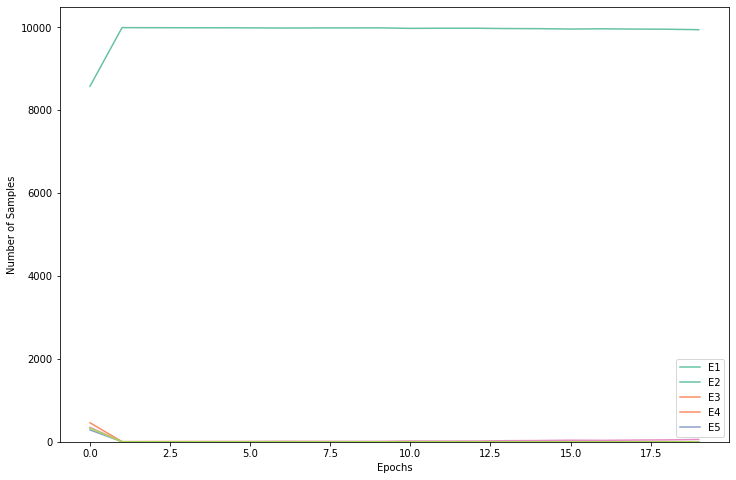

tensor([7, 2, 1,  ..., 3, 9, 5])


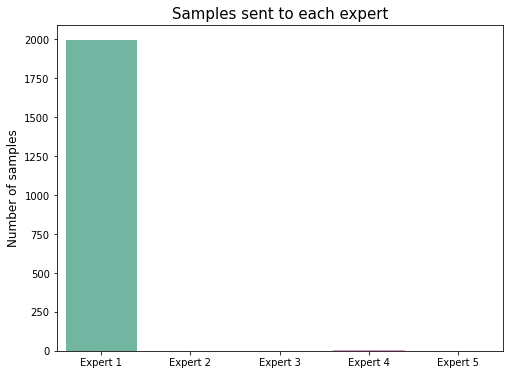

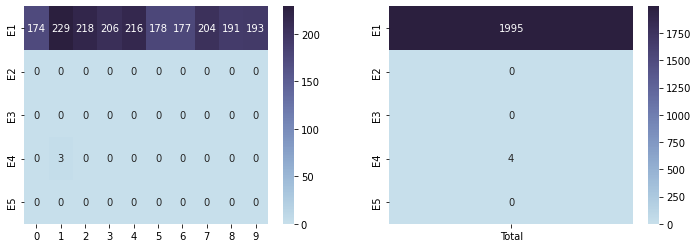


Experts used by the gate for classification of each digit


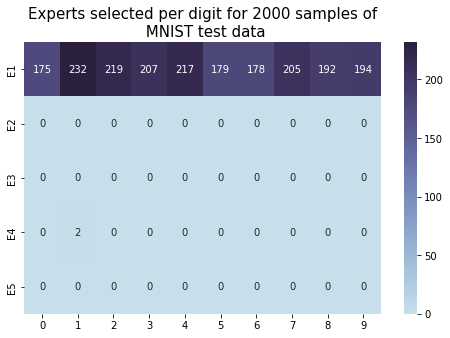

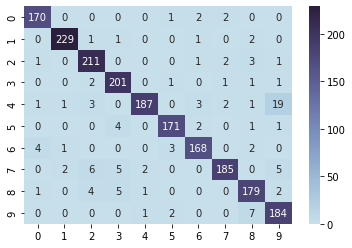

In [57]:
m = "mnist_without_reg_hidden_32"
test_loader = testloader
plot_expert_usage(m, test_loader, classes=range(10) )

Min Validation Error 0.057
mnist_with_reg_hidden_32_importance_0.6_10_5_models.pt
20 torch.Size([20, 10000, 5])


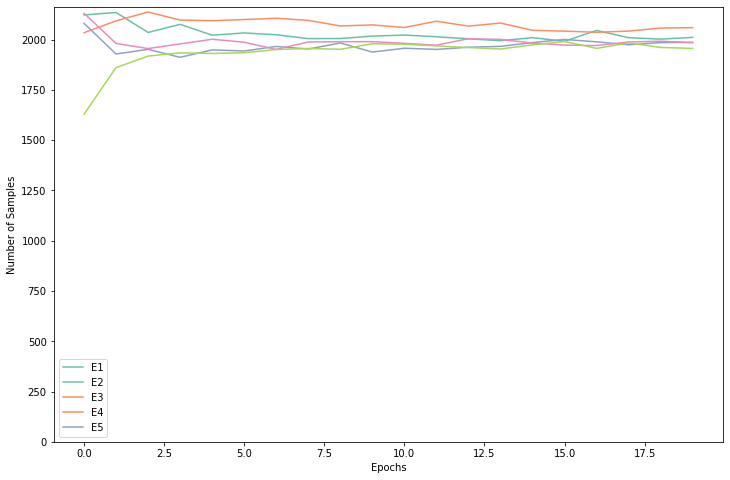

tensor([7, 2, 1,  ..., 3, 9, 5])


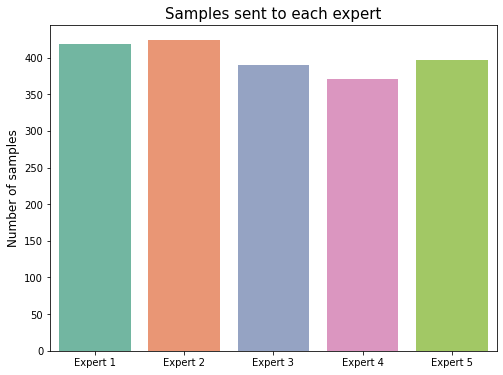

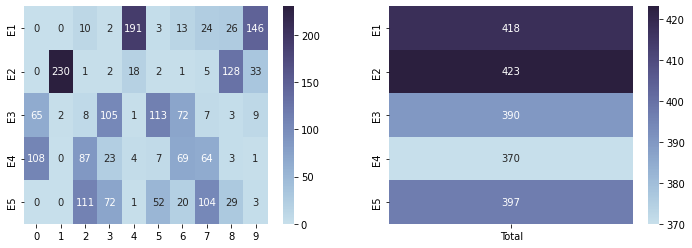


Experts used by the gate for classification of each digit


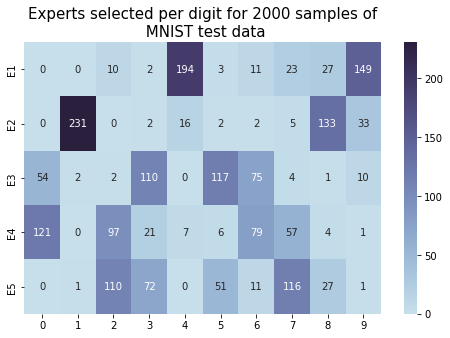

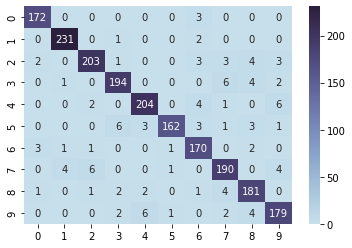

In [55]:
m = "mnist_with_reg_hidden_32"
test_loader = testloader
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,classes=range(10) )

Min Validation Error 0.054
mnist_with_reg_hidden_32_sample_sim_same_0.0001_sample_sim_diff_0.01_10_5_models.pt
20 torch.Size([20, 10000, 5])


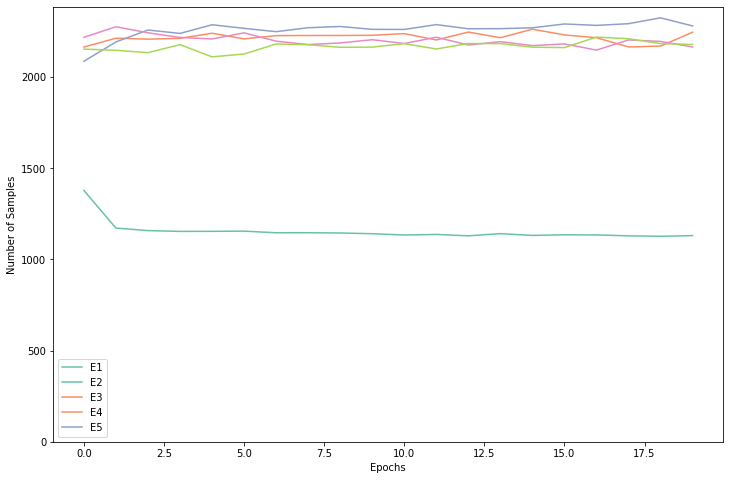

tensor([7, 2, 1,  ..., 3, 9, 5])


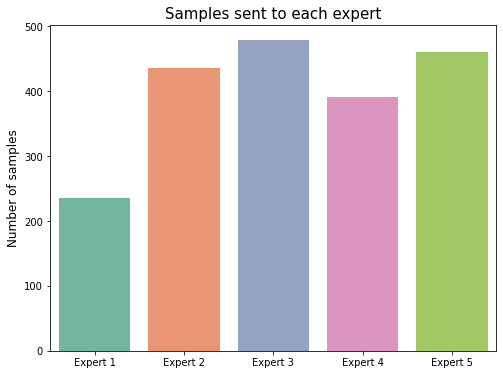

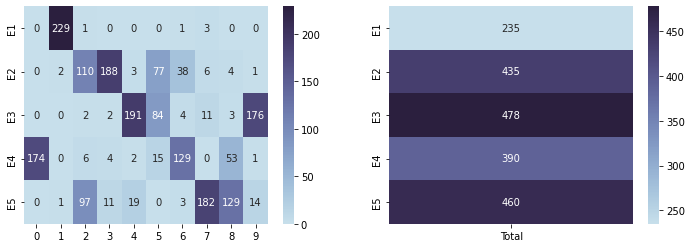


Experts used by the gate for classification of each digit


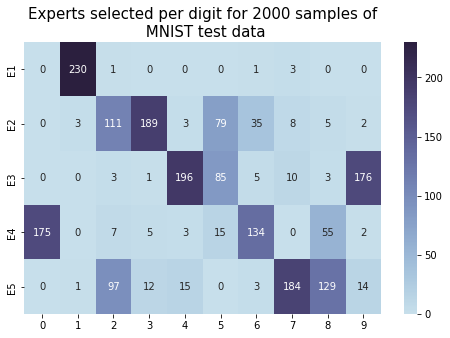

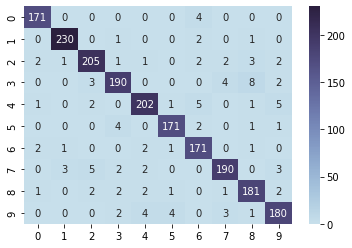

In [56]:
m = "mnist_with_reg_hidden_32"
test_loader = testloader
w_sample_sim_same_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_diff_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
plot_expert_usage(m, test_loader, w_sample_sim_same_range=w_sample_sim_same_range,w_sample_sim_diff_range=w_sample_sim_diff_range,classes=range(10) )

temps [1.1 1.2 1.3 1.4 1.5 2.  4.  6. ]
w_importance_range [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

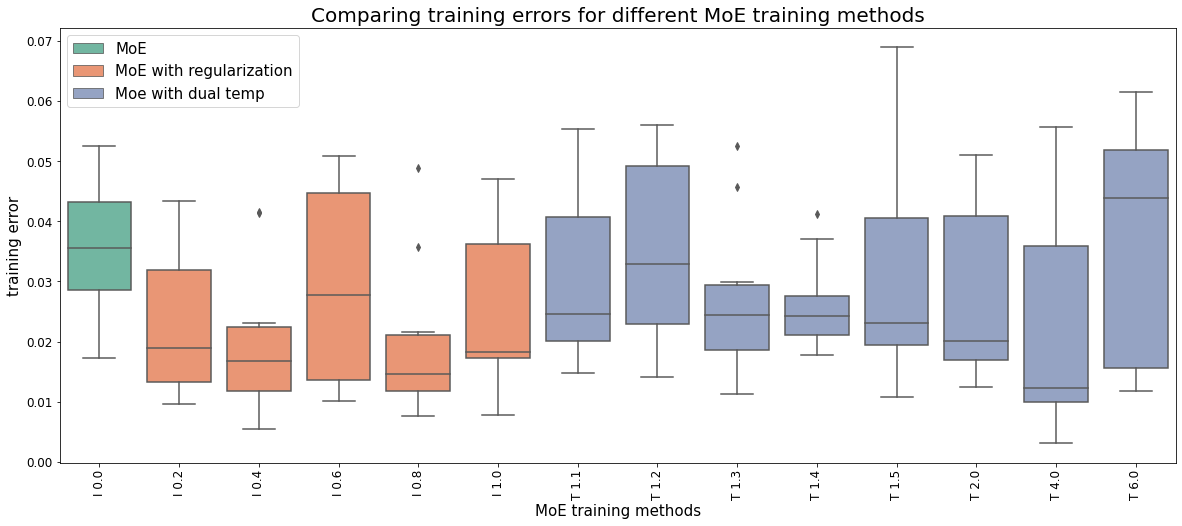

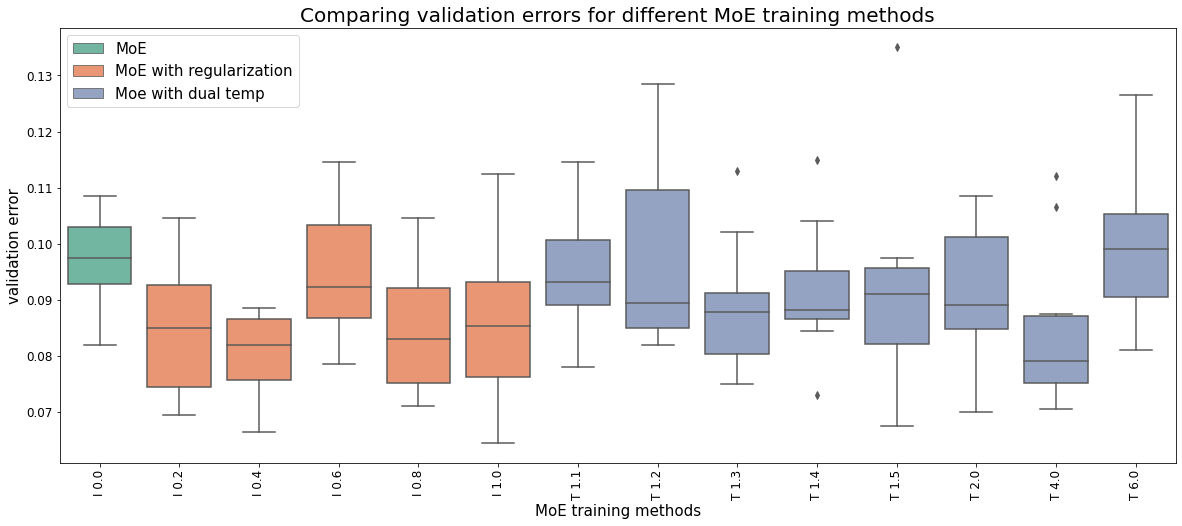

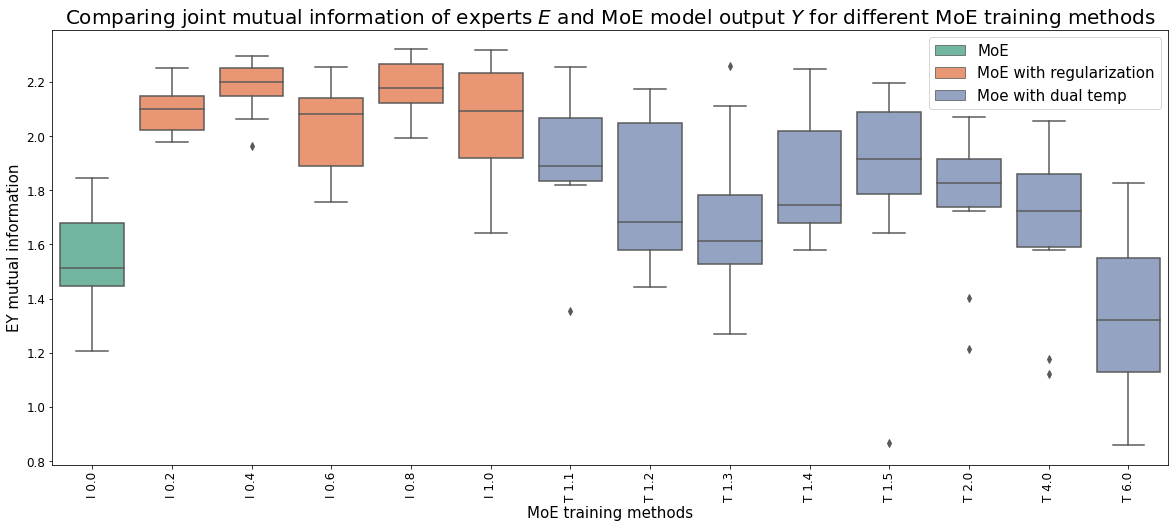

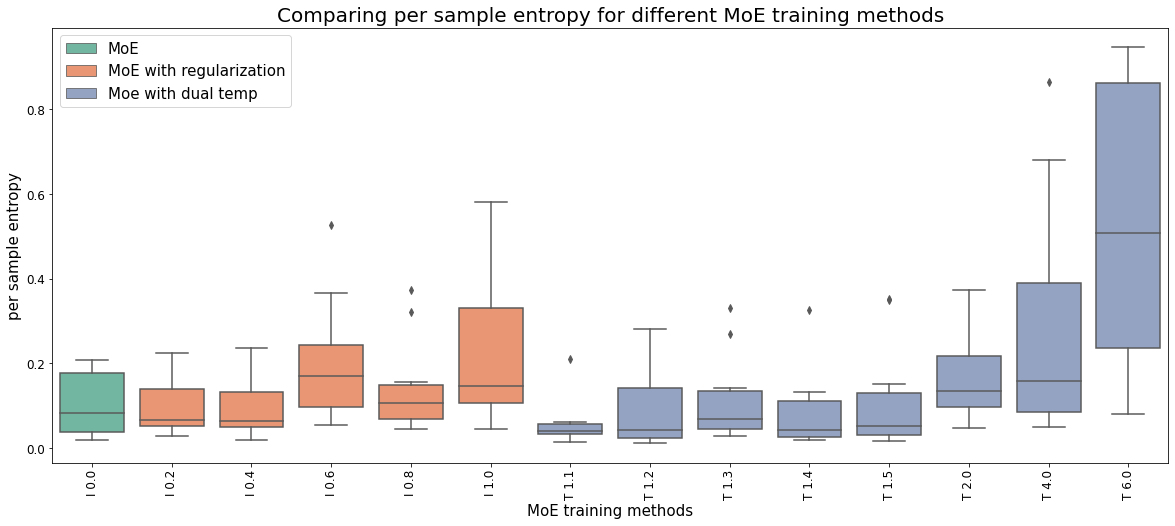

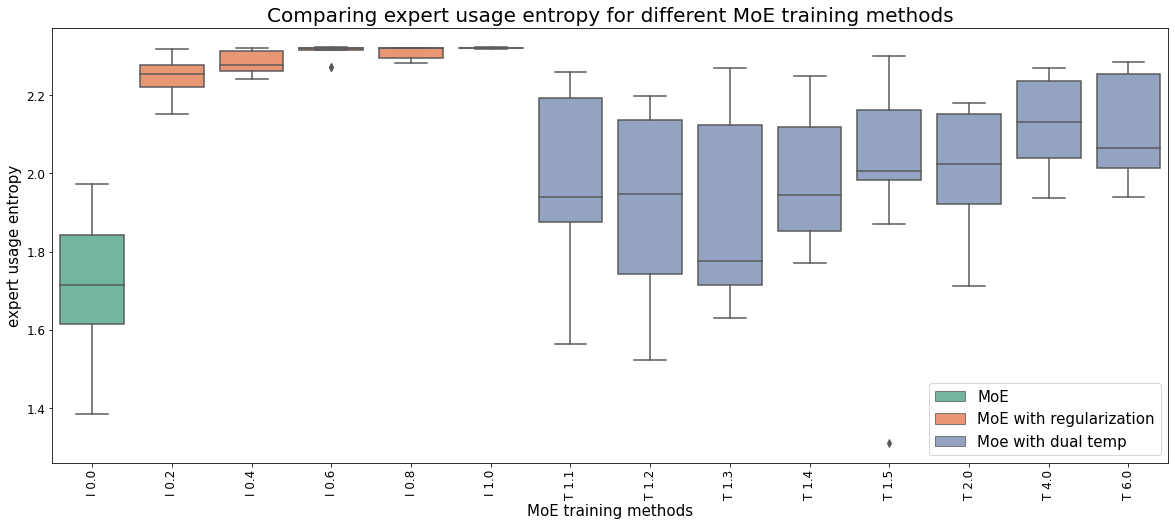

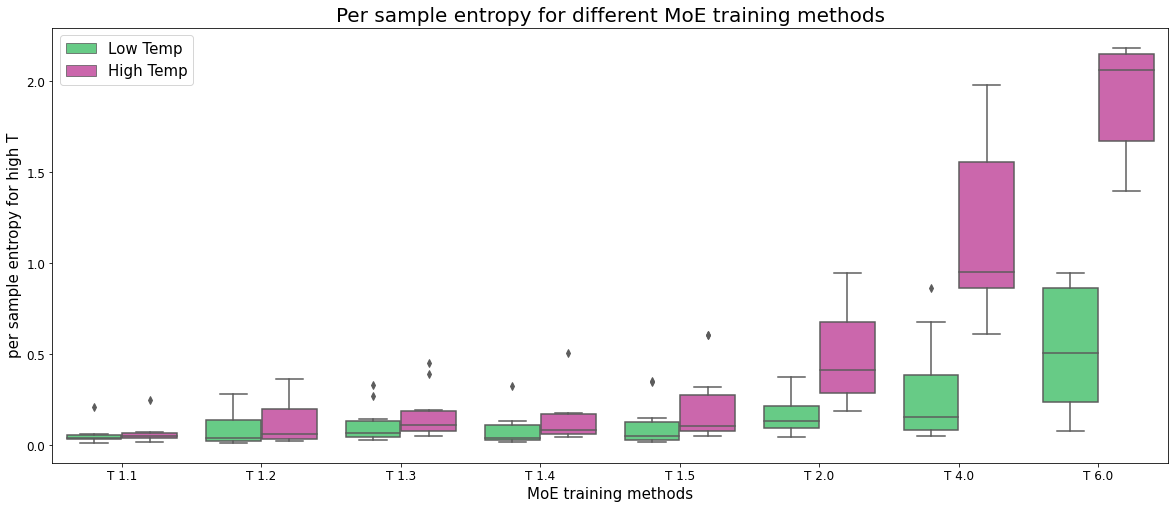

In [54]:
model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_reg'
model_without_reg = 'mnist_without_reg'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 21, 2), np.arange(25, 51, 5)))
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 7, 2)))
print('temps', temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range', w_importance_range)
        
boxplot(
        model_with_reg=model_with_reg, 
        model_without_reg=model_without_reg, 
        model_with_temp = model_with_temp, 
        temps=temps,w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), 
        testloader=testloader, figname='mnist_dual_temp')

temps [1.1 1.2 1.3 1.4 1.5 2.  4.  6. ]
w_importance_range [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

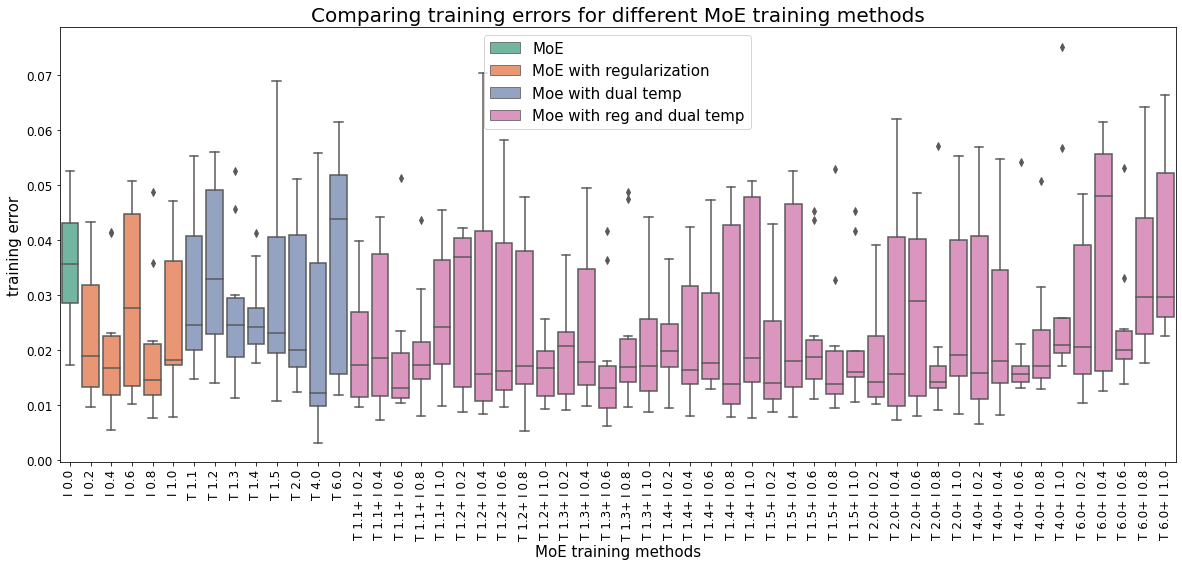

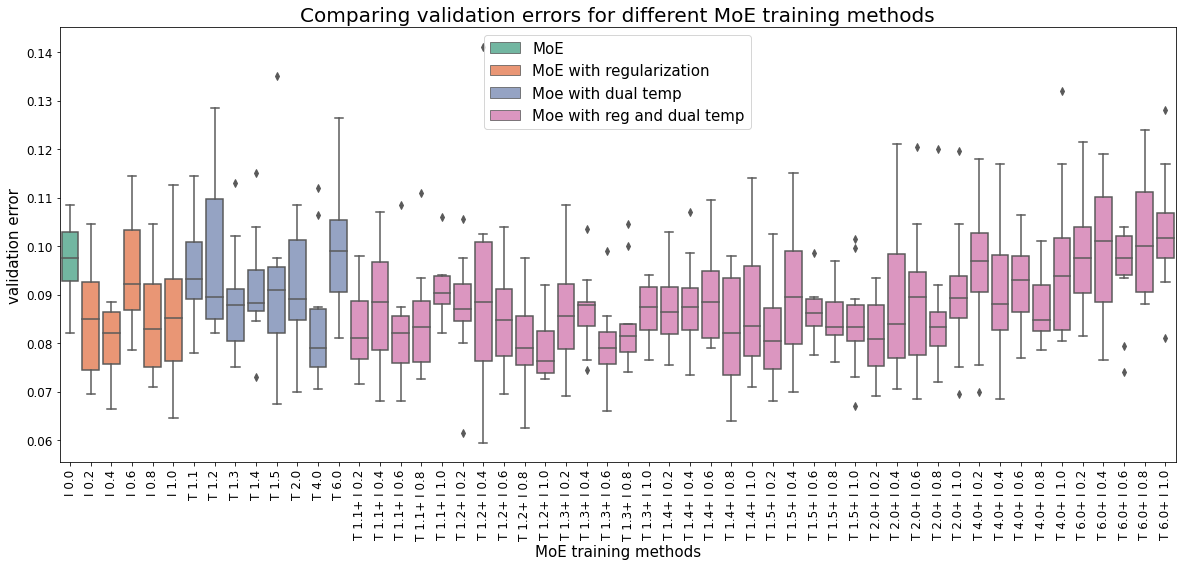

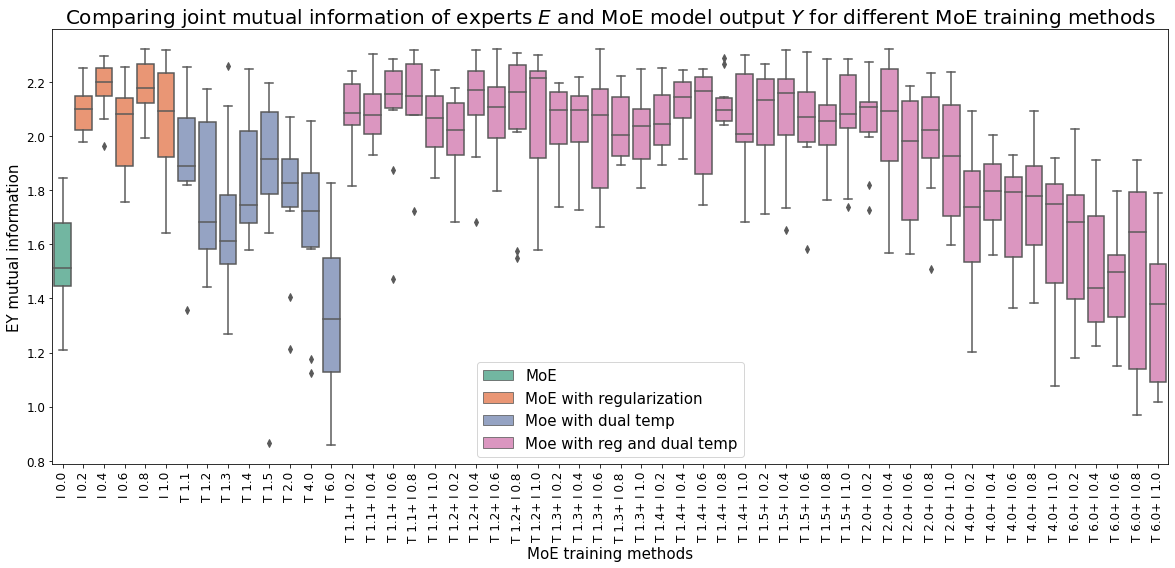

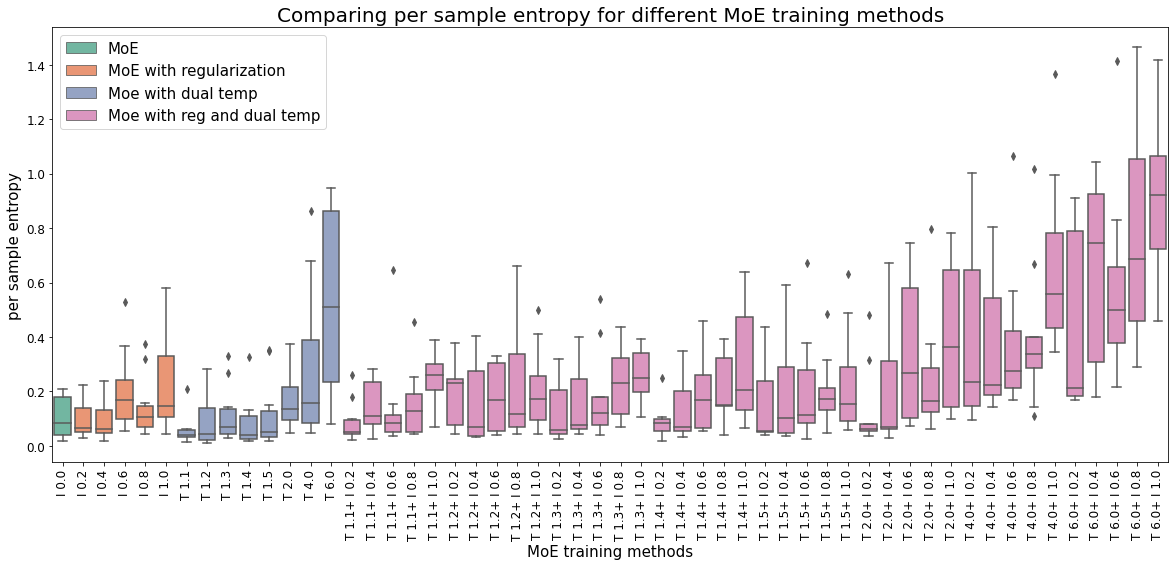

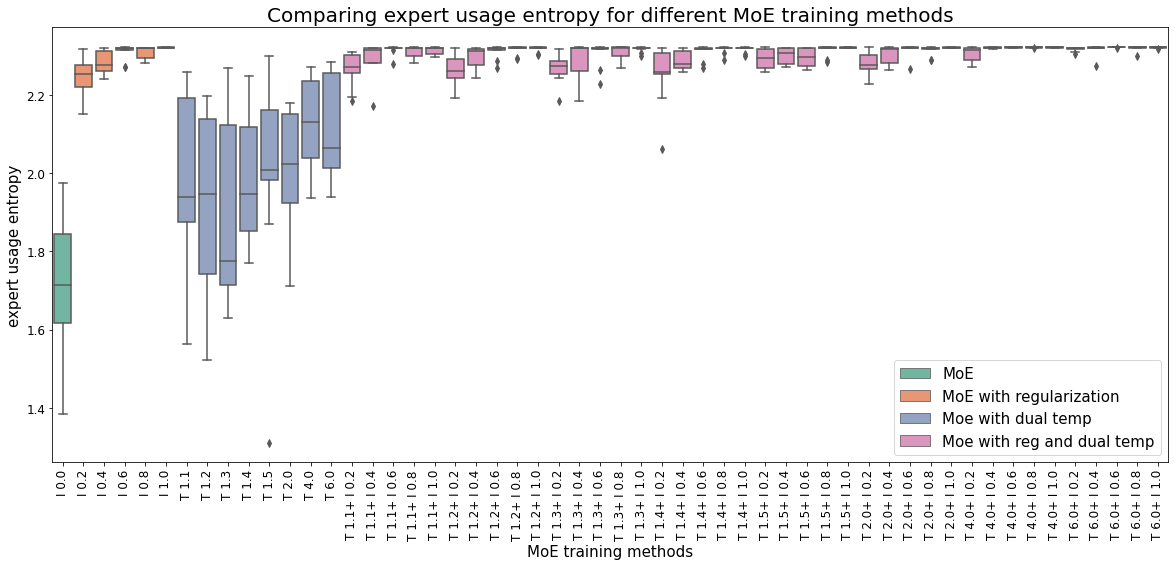

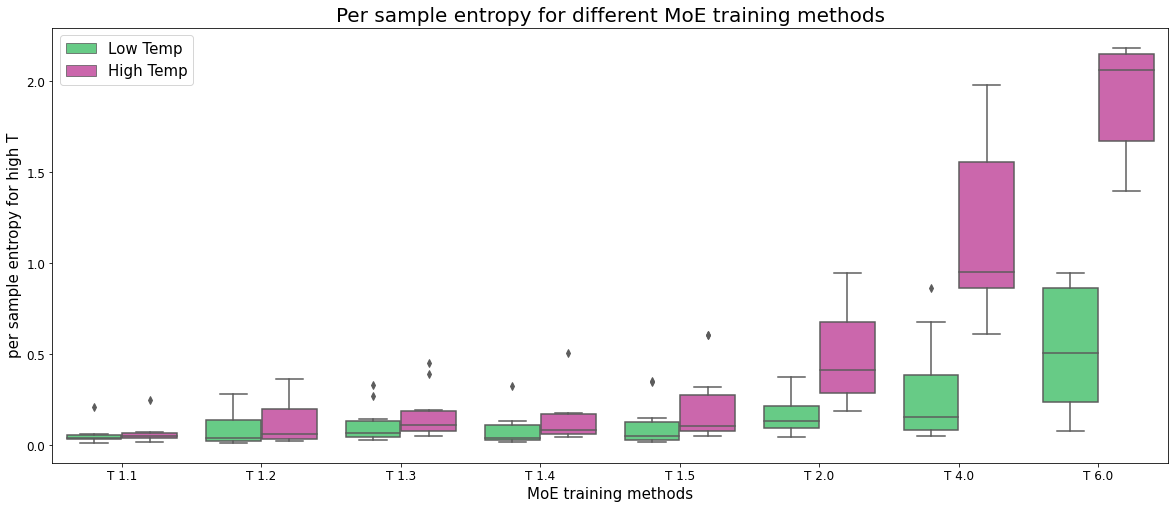

In [55]:
model_with_temp = 'mnist_dual_temp'
model_with_reg_temp = 'mnist_dual_temp_with_reg'
model_with_reg = 'mnist_with_reg'
model_without_reg = 'mnist_without_reg'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 21, 2), np.arange(25, 51, 5)))
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 7, 2)))
print('temps', temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range', w_importance_range)
        
boxplot(
        model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_with_temp = model_with_temp, model_with_reg_temp=model_with_reg_temp,
        temps=temps,w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), 
        testloader=testloader, figname='mnist_dual_temp_with_reg')

temps [1.0]
w_importance_range [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]
w_sample_sim_same_range [1e-05, 0.0001, 0.001, 0.01, 0.1]
w_sample_sim_diff_range [1e-05, 0.0001, 0.001, 0.01, 0.1]


<Figure size 432x288 with 0 Axes>

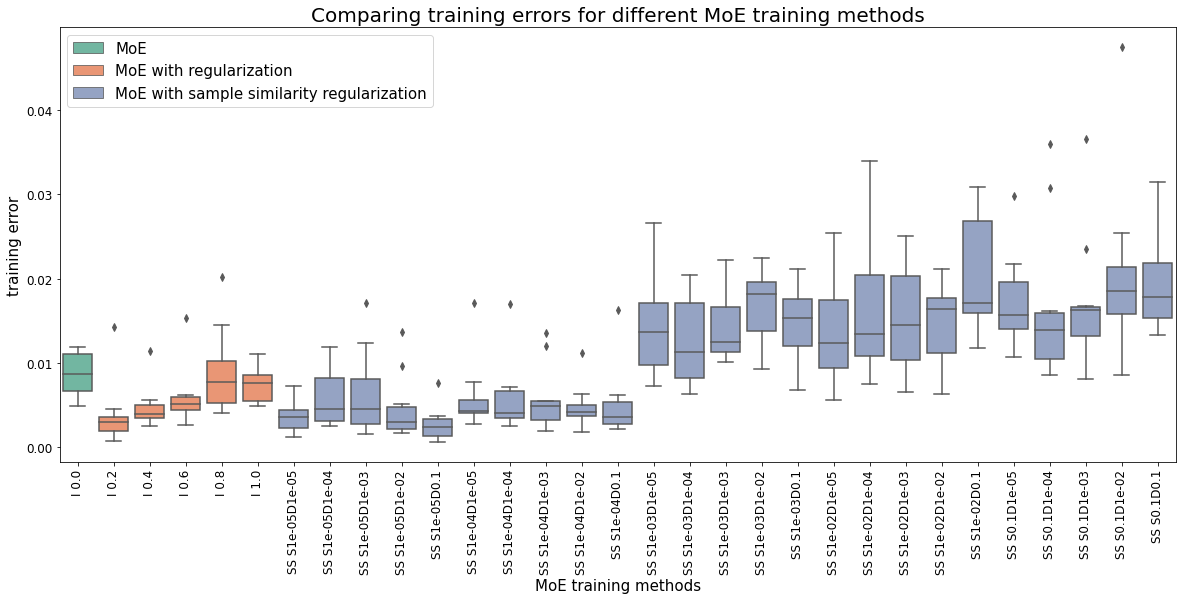

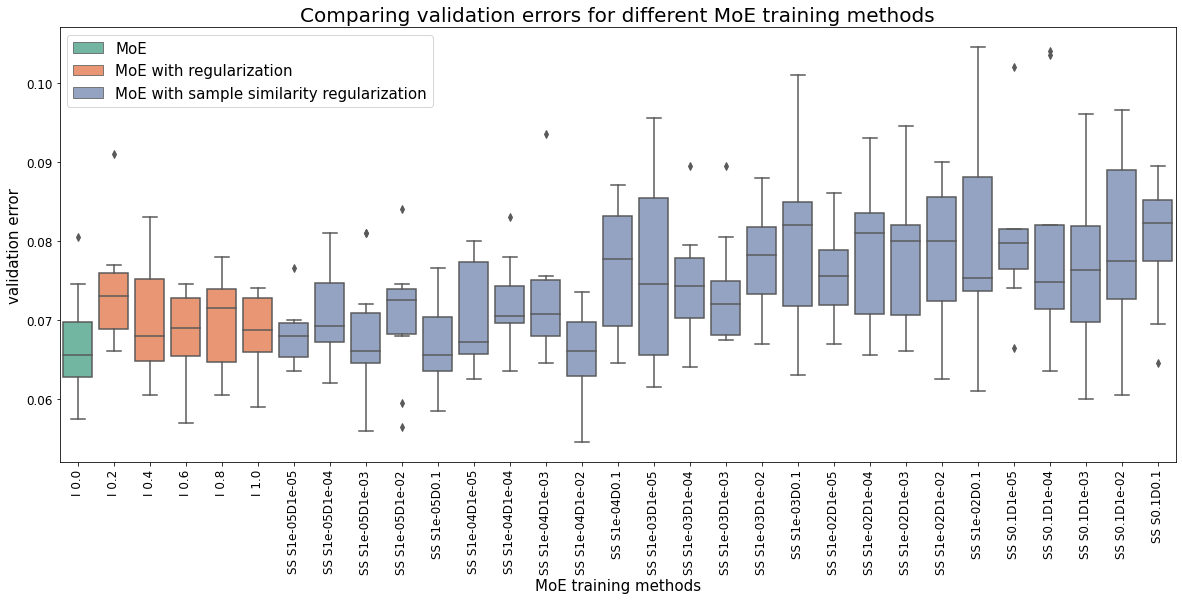

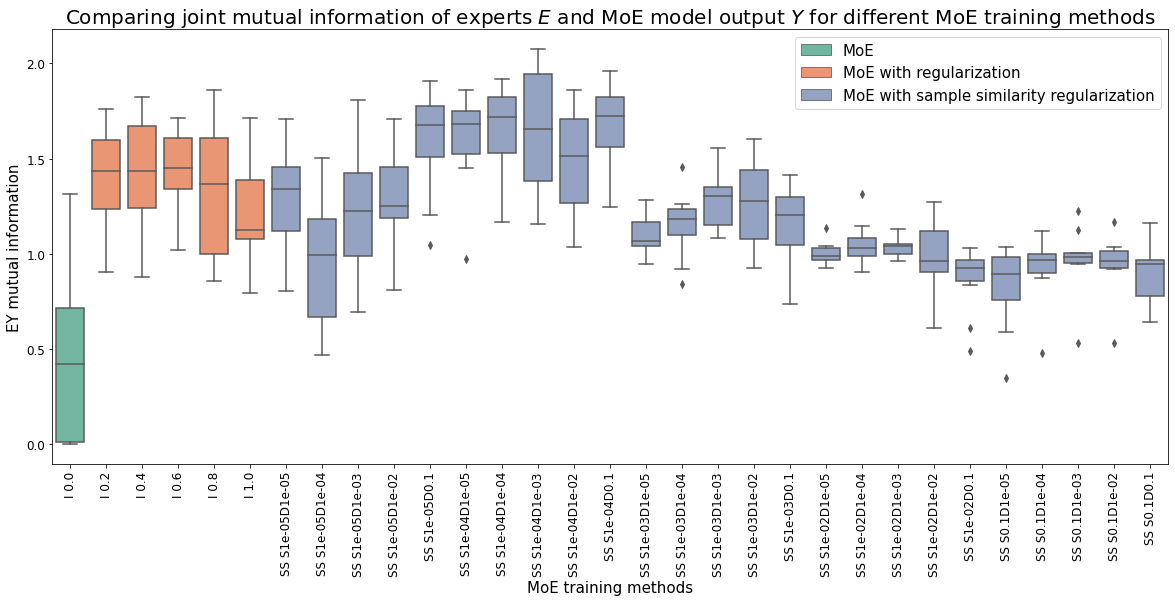

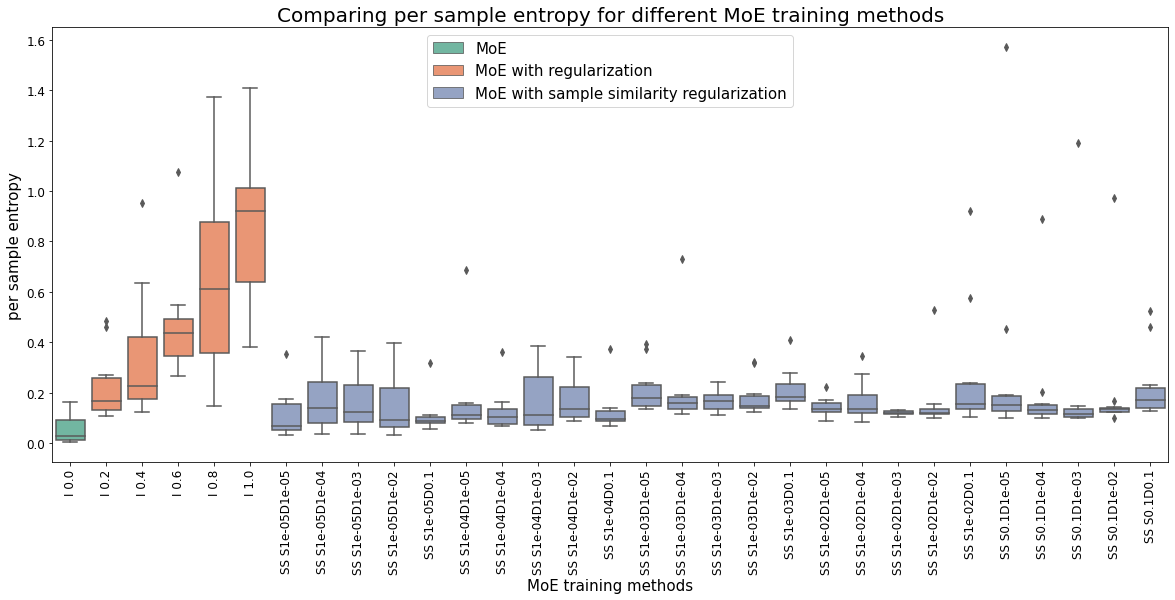

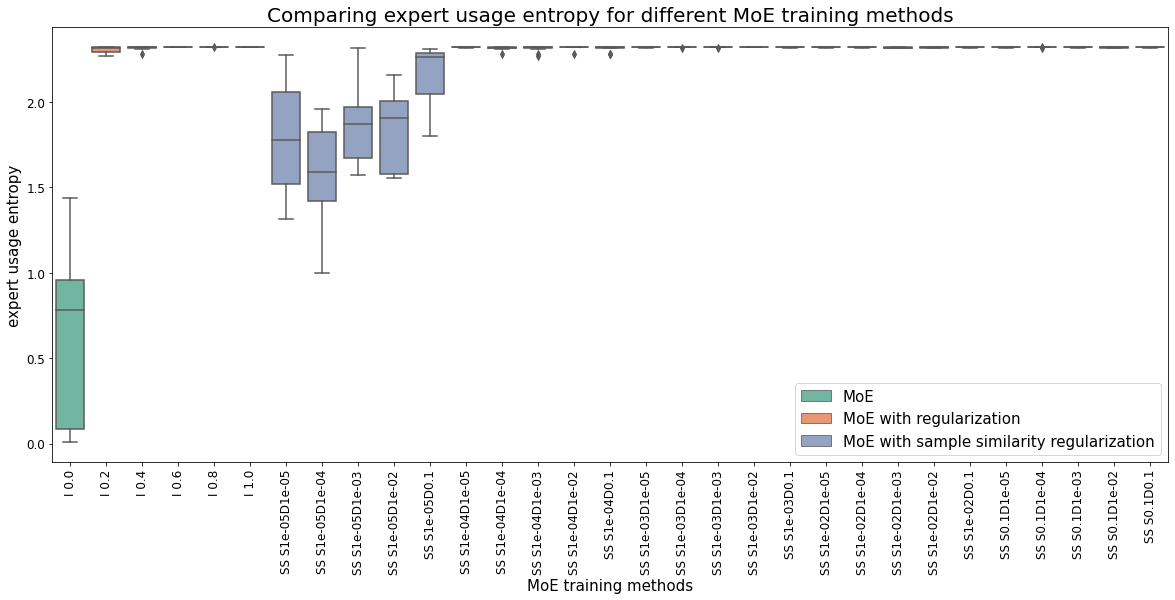

In [86]:
# model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_reg_hidden_32'
model_without_reg = 'mnist_without_reg_hidden_32'
model_sample_sim_reg = 'mnist_with_reg_hidden_32'

total_experts = 5
num_classes = 10

temps=[1.0]
print('temps', temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range', w_importance_range)
w_sample_sim_same_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_diff_range = [1e-5,1e-4,1e-3,1e-2,1e-1]

print('w_sample_sim_same_range', w_sample_sim_same_range)
print('w_sample_sim_diff_range', w_sample_sim_diff_range)

boxplot(
        model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_sample_sim_reg = model_sample_sim_reg,
        temps=temps,w_importance_range=w_importance_range,
        w_sample_sim_same_range=w_sample_sim_same_range,
        w_sample_sim_diff_range = w_sample_sim_diff_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), 
        testloader=testloader, figname='mnist_sample_sim_hidden_32')

In [ ]:
model_single = 'mnist_single_model'
model_with_temp = 'mnist_dual_temp'
model_with_temp_decay = 'mnist_dual_temp_on_schedule'
model_with_temp_decay_reg = 'mnist_dual_temp_on_schedule'
model_with_reg = 'mnist_with_reg'
# model_with_reg = 'mnist_with_reg_test'
model_without_reg = 'mnist_without_reg'
model_with_reg_temp = 'mnist_dual_temp_with_reg'
# model_with_reg_temp = 'mnist_dual_temp_with_reg_test'
model_output_reg = 'mnist_output_reg'
model_output_imp_reg = 'mnist_output_imp_reg'
model_temp_output_reg = 'mnist_dual_temp_output_reg'
model_with_exp_reg = 'mnist_with_exp_reg'
model_sample_sim_reg = 'mnist_with_reg_test'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 21, 2), np.arange(25, 51, 5)))
# temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 7, 2)))
print(temps)
# temps = [20]
w_importance_range = [i * 0.2 for i in range(1, 6)]
# w_importance_range = [0.4]
w_ortho_range = [i * 0.2 for i in range(1, 6)]
w_sample_sim_range = [i * 0.2 for i in range(1, 6)]
w_exp_gamma_range = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1.0]
        
boxplot(
#     model_single=model_single, 
        model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_with_temp = model_with_temp, 
#         model_with_temp_decay = model_with_temp_decay,
#         model_with_temp_decay_reg = model_with_temp_decay_reg,
        model_with_reg_temp=model_with_reg_temp,
#         model_sample_sim_reg=model_sample_sim_reg,
#         mnist_attn_output_reg=mnist_attn_output_reg,
#         model_with_exp_reg = model_with_exp_reg,
        temps=temps,w_importance_range=w_importance_range,w_ortho_range=w_ortho_range,
        w_sample_sim_range=w_sample_sim_range,w_exp_gamma_range=w_exp_gamma_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), 
        testloader=testloader, figname='mnist')

In [ ]:
model_output_reg = 'mnist_output_reg'
model_with_reg = 'mnist_with_regularization'
model_output_imp_reg = 'mnist_output_imp_reg'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps = [1.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_ortho_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_with_reg=model_with_reg, model_output_reg=model_output_reg, model_output_imp_reg=model_output_imp_reg, 
        temps=temps,w_importance_range=w_importance_range,w_ortho_range=w_ortho_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), testloader=testloader)

In [ ]:
model_single = 'imbalanced_mnist_single_model'
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_temp_on_delay = 'mnist_imbalanced_5_dual_temp_on_schedule'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
model_with_reg_temp = 'mnist_imbalanced_5_dual_temp_with_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps = [1.2, 2.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_single, model_with_temp, model_with_temp_on_delay, model_with_reg, model_without_reg, model_with_reg_temp, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_single = 'rot_mnist_single_model'
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(0.5,1.0,0.1), np.arange(1.1,1.6,0.1), np.arange(2,6) ))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
boxplot(model_single, model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

In [ ]:
model_single = 'fmnist_mnist_single_model'
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
boxplot(model_single, model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

### Results for MNIST data

In [ ]:
model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'
total_experts = 5
num_classes = 10
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

### Results for combined FMNIST and MNIST data

In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

[1.1, 1.5, 2, 10, 20, 30, 40, 50]
Temperature 1.1
Importance 0.0
Sample sim 0.0
Temperature 1.5
Importance 0.0
Sample sim 0.0
Temperature 2.0
Importance 0.0
Sample sim 0.0
Temperature 10.0
Importance 0.0
Sample sim 0.0
Temperature 20.0
Importance 0.0
Sample sim 0.0
Temperature 30.0
Importance 0.0
Sample sim 0.0
Temperature 40.0
Importance 0.0
Sample sim 0.0
Temperature 50.0
Importance 0.0
Sample sim 0.0


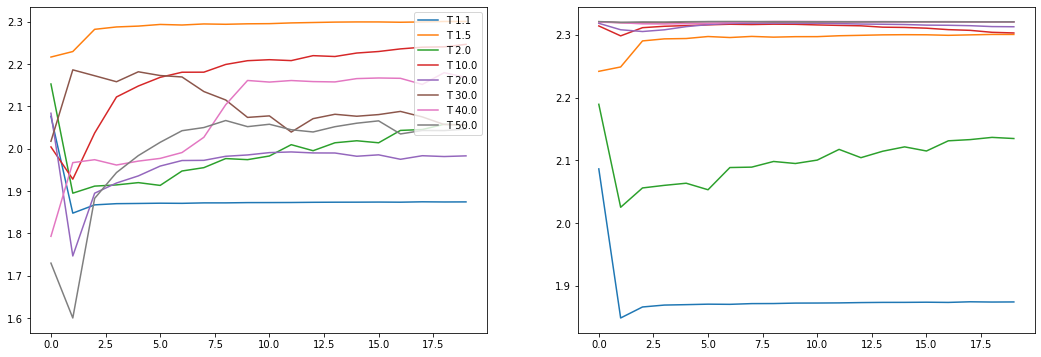

In [70]:
model_with_temp = 'mnist_dual_temp'

total_experts = 5
num_epochs = 20

temps = list(np.arange(1.1,1.6,0.1))+ list(np.arange(2,21,2))+list(np.arange(25,51,5))
temps = [1.1,1.5, 2,10,20,30,40,50]
print(temps)

caption = 'Distribution of samples to experts by the gate, \n during training, with low temperature (T=1)\n'

plot_expert_usage(model_with_temp, temps, total_experts=total_experts, num_classes=num_classes, 
               classes=range(num_classes), num_epochs=num_epochs, 
               testloader=testloader, caption=caption, index=1)

In [54]:
import pandas as pd

def plot_gate_prob(model_name, temps=[1.0], w_importance_range=[0], w_sample_sim_range=[0], 
                   total_experts=5, num_classes=10, classes=None, num_epochs=20, 
                   testloader=None, caption=None, index=0):
    
    m = model_name
    
    for T, w_importance, w_sample_sim in product(temps, w_importance_range, w_sample_sim_range):
                    
        y_gate_prob = {} 
        y_gate_prob_T = {} 
        
        print('Temperature','{:.1f}'.format(T))
        print('Importance','{:.1f}'.format(w_importance))
        print('Sample sim','{:.1f}'.format(w_sample_sim))

        plot_file = generate_plot_file(m, temp=T, w_importance=w_importance, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        model = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[index]
        palette = sns.color_palette("Set2")
        fig,ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18, 6))
        fontsize = 20
        label_fontsize = 15

        for e_key, e_val in model.items():
            history = model[e_key]['experts'][total_experts]['history']
            gate_probability = torch.vstack(history['gate_probabilities']).view(num_epochs, -1, total_experts)
            gate_probabilities_sum = torch.sum(gate_probability, dim=1).detach().cpu().numpy()
            
            if T > 1:
                gate_probability_T = torch.vstack((history['gate_probabilities_T'])).view(num_epochs, -1, total_experts)
                gate_probabilities_T_sum = torch.sum(gate_probability_T, dim=1).detach().cpu().numpy()
            
            labels = []
            for epoch in range(num_epochs):
                for e in range(total_experts):
                    y_gate_prob['Expert '+str(e+1)] = gate_probabilities_sum[:,e]
                    
                    if T > 1:
                        y_gate_prob_T['Expert'+str(e+1)] = gate_probabilities_T_sum[:,e]
                    
                    labels.append('E'+str(e))
            df = pd.DataFrame(y_gate_prob, index=list(range(1,num_epochs+1)))
            df.plot(kind='bar', stacked=True, color=palette, ax=ax[0])   
            ax[0].legend(loc='upper right') 
            ax[0].set_ylabel('Number of samples per expert', fontsize=label_fontsize)
            ax[0].set_xlabel('Epochs', fontsize=label_fontsize)
            ax[0].set_title(caption, 
                            loc='center', wrap=True, fontsize=fontsize)
            if T > 1:
                df_T = pd.DataFrame(y_gate_prob_T, index=list(range(1,num_epochs+1)))            
                df_T.plot(kind='bar', stacked=True, color=palette, ax=ax[1])
                ax[1].legend(loc='upper right') 
                ax[1].set_ylabel('Number of samples per expert', fontsize=label_fontsize)
                ax[1].set_xlabel('Epochs', fontsize=label_fontsize)
                ax[1].set_title('Distribution of samples to experts by the gate, \n during training, with high temperature (T='+'{:.1f}'.format(T)+')\n', 
                                loc='center', wrap=True, fontsize=fontsize)
            else:
                ax[1].axis('off')
                
            plt.tight_layout()
            plot_file = generate_plot_file(m, temp=T, w_importance=w_importance, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_barplot.png')
            if T>1:
                plt.savefig(os.path.join(fig_path, plot_file))
            else:
                extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
                plt.savefig(os.path.join(fig_path, plot_file), bbox_inches=extent.expanded(1.3, 1.5))
            plt.show()
            


[1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000004, 1.5000000000000004, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50]
Temperature 1.1
Importance 0.0
Sample sim 0.0


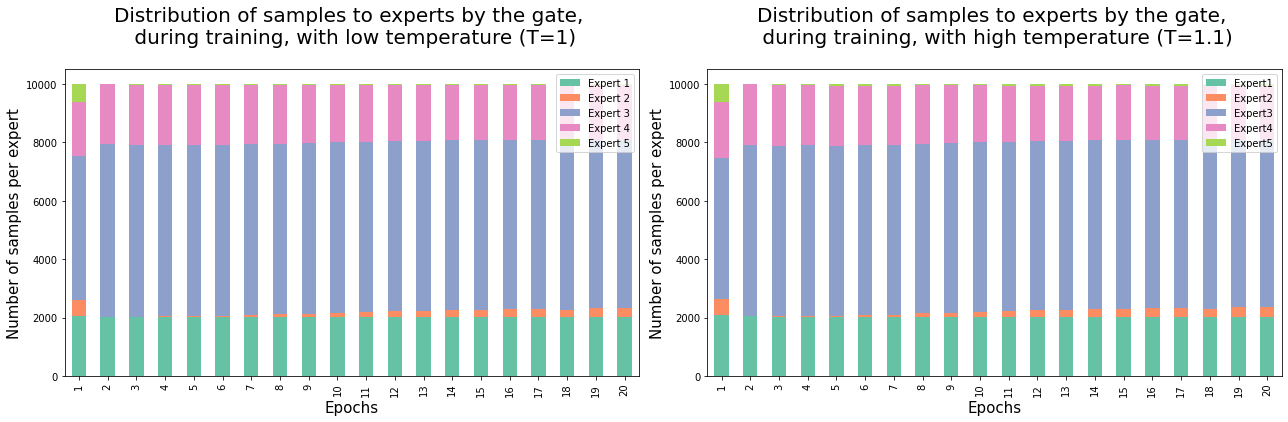

Temperature 1.2
Importance 0.0
Sample sim 0.0


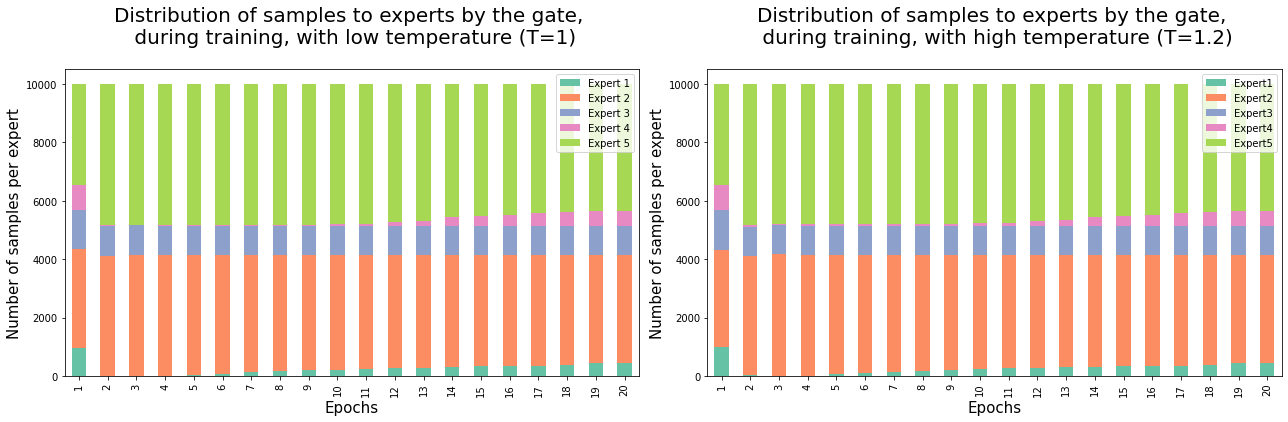

Temperature 1.3
Importance 0.0
Sample sim 0.0


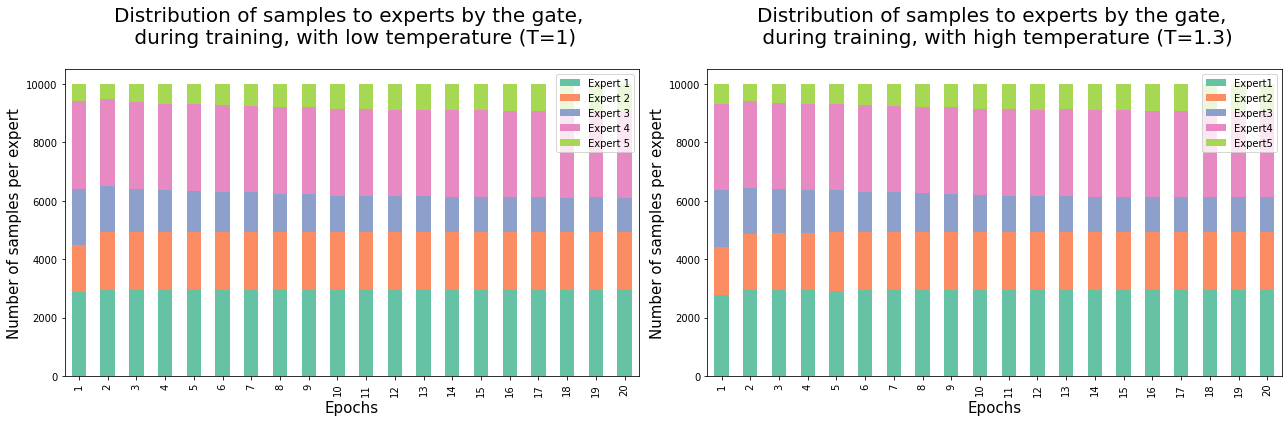

Temperature 1.4
Importance 0.0
Sample sim 0.0


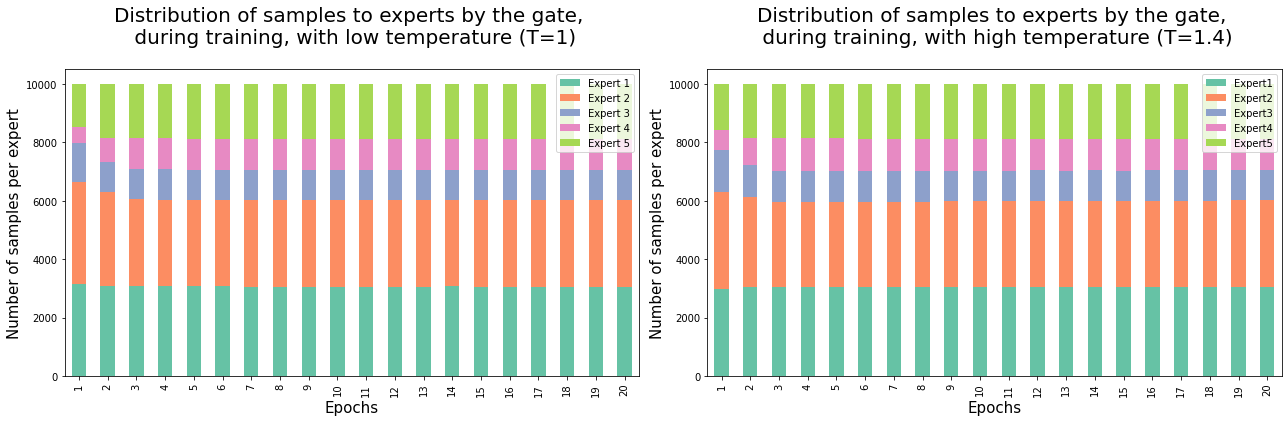

Temperature 1.5
Importance 0.0
Sample sim 0.0


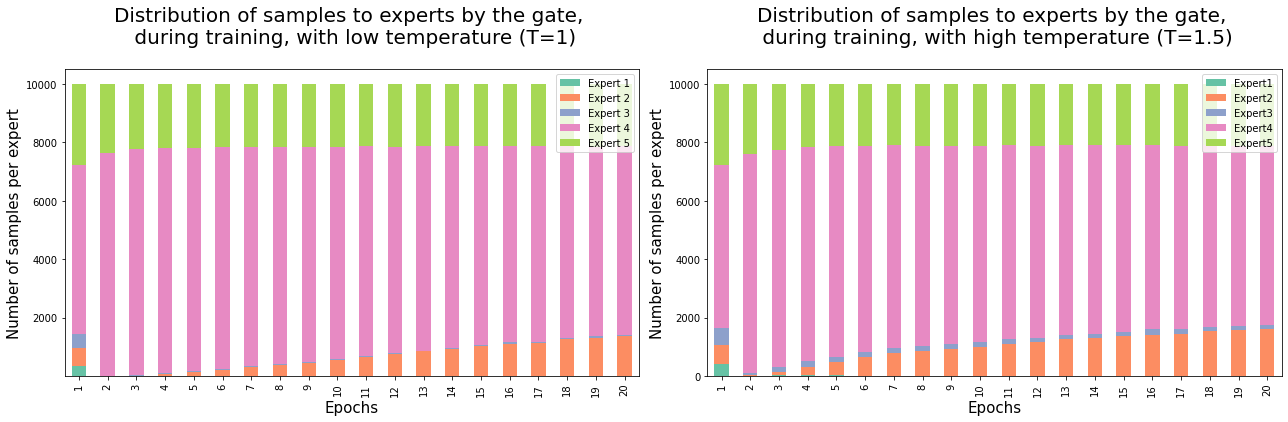

Temperature 2.0
Importance 0.0
Sample sim 0.0


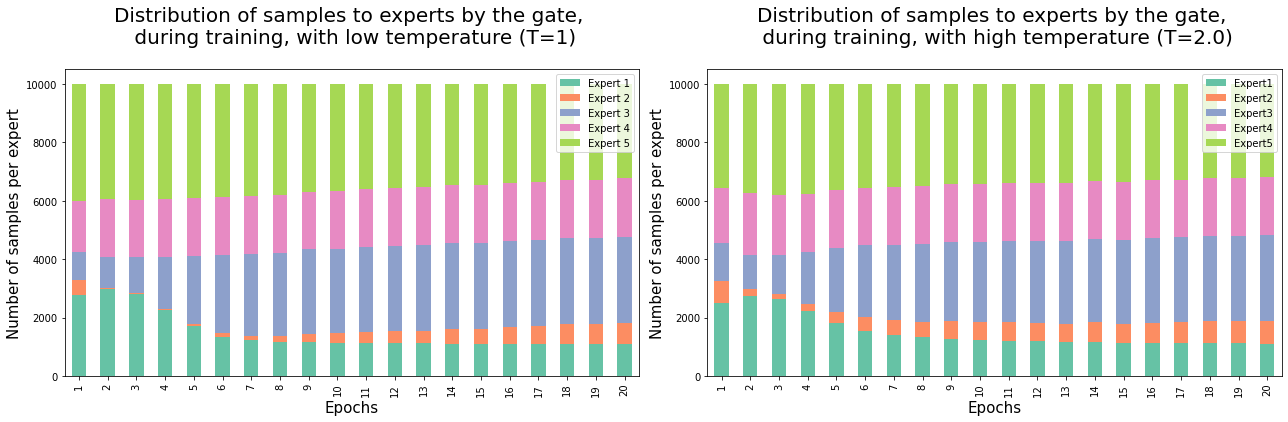

Temperature 4.0
Importance 0.0
Sample sim 0.0


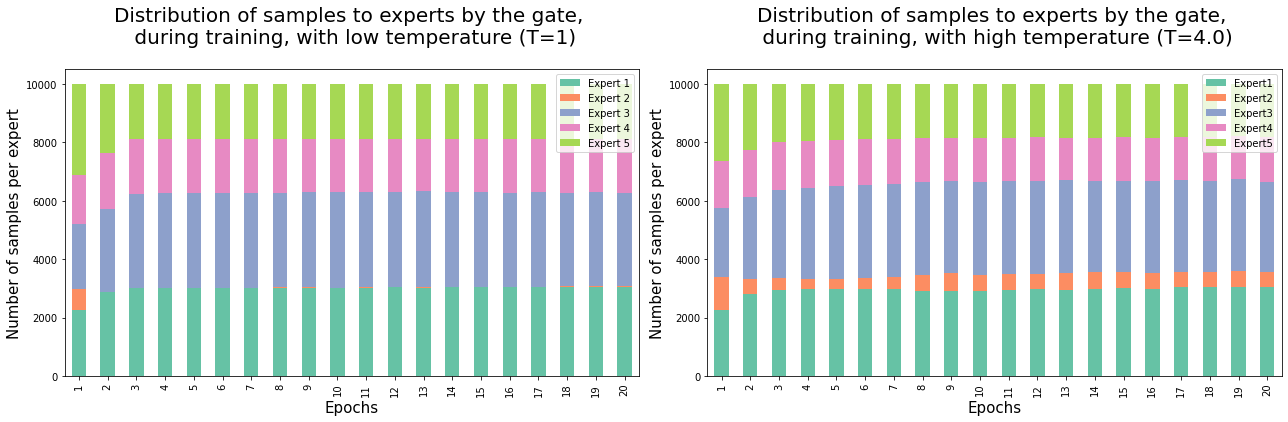

Temperature 6.0
Importance 0.0
Sample sim 0.0


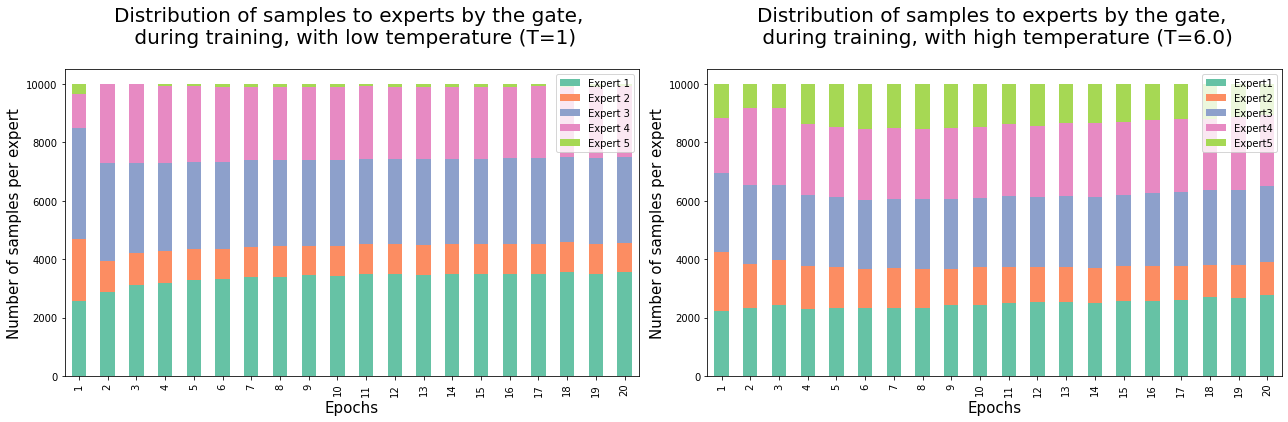

Temperature 8.0
Importance 0.0
Sample sim 0.0


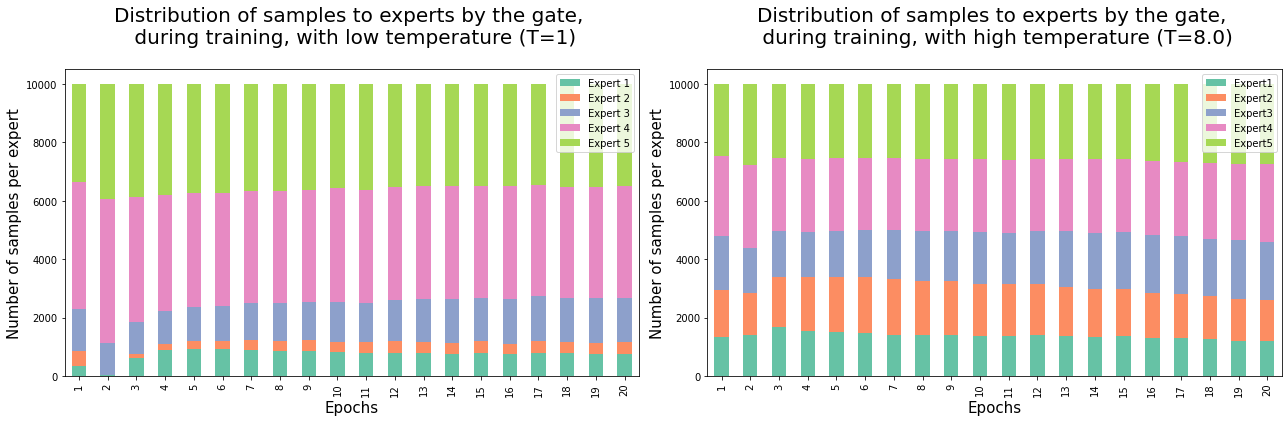

Temperature 10.0
Importance 0.0
Sample sim 0.0


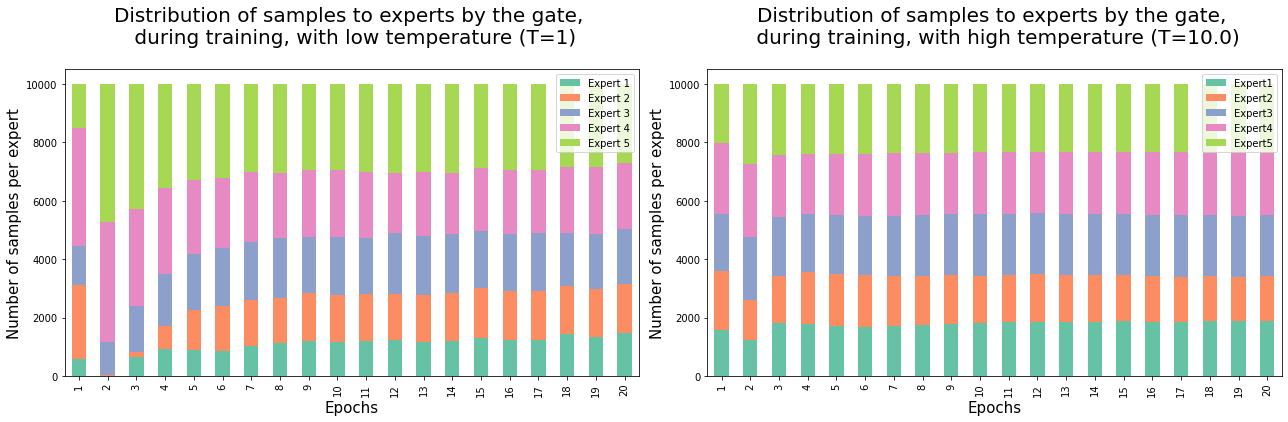

Temperature 12.0
Importance 0.0
Sample sim 0.0


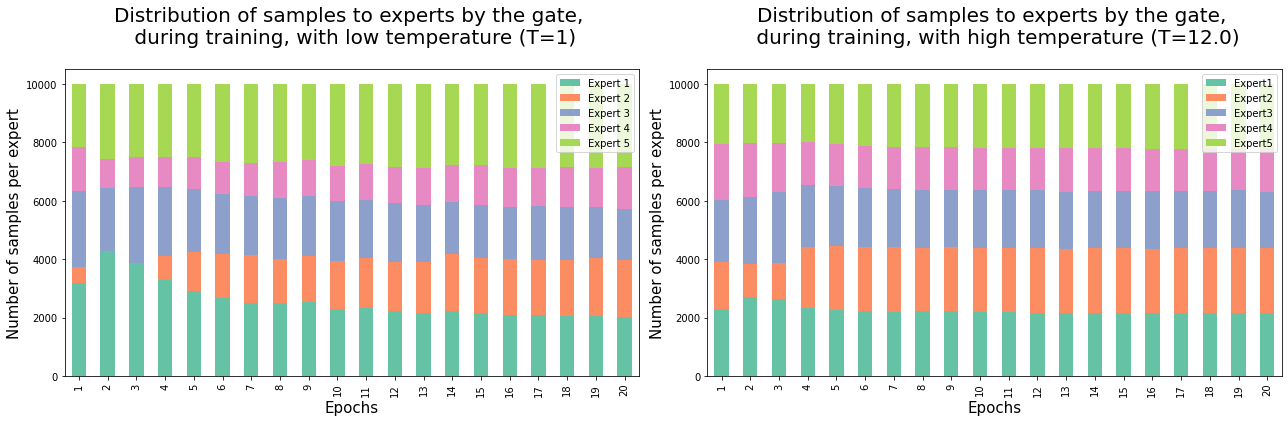

Temperature 14.0
Importance 0.0
Sample sim 0.0


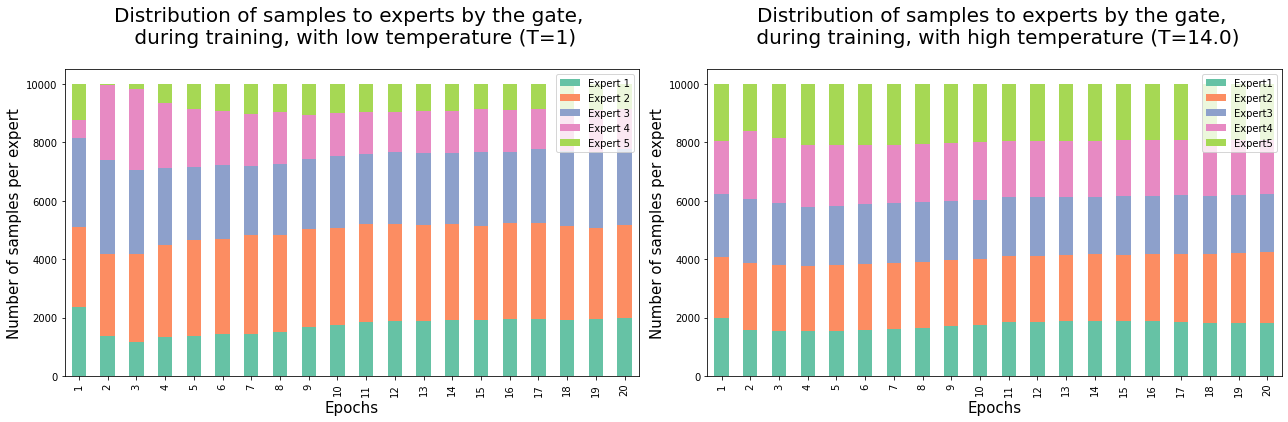

Temperature 16.0
Importance 0.0
Sample sim 0.0


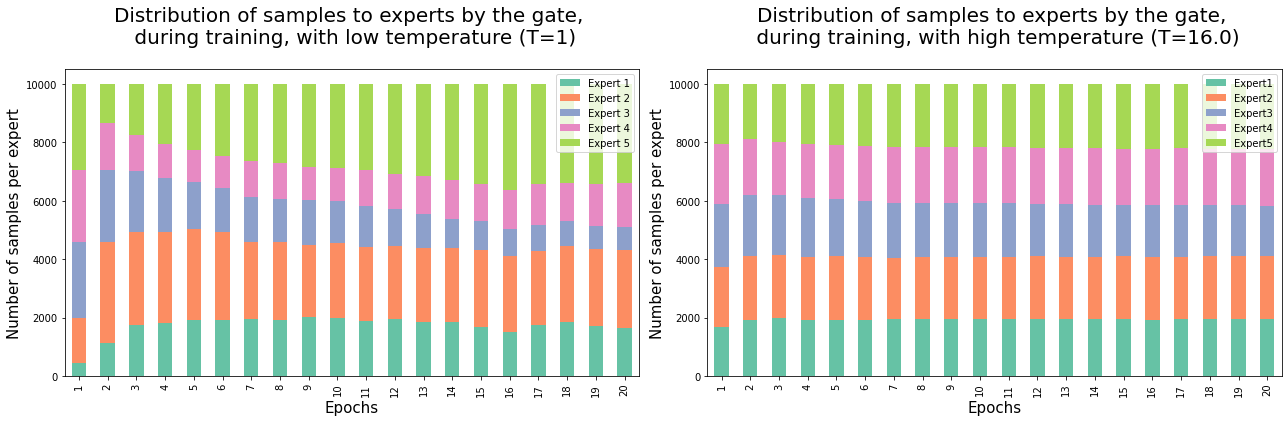

Temperature 18.0
Importance 0.0
Sample sim 0.0


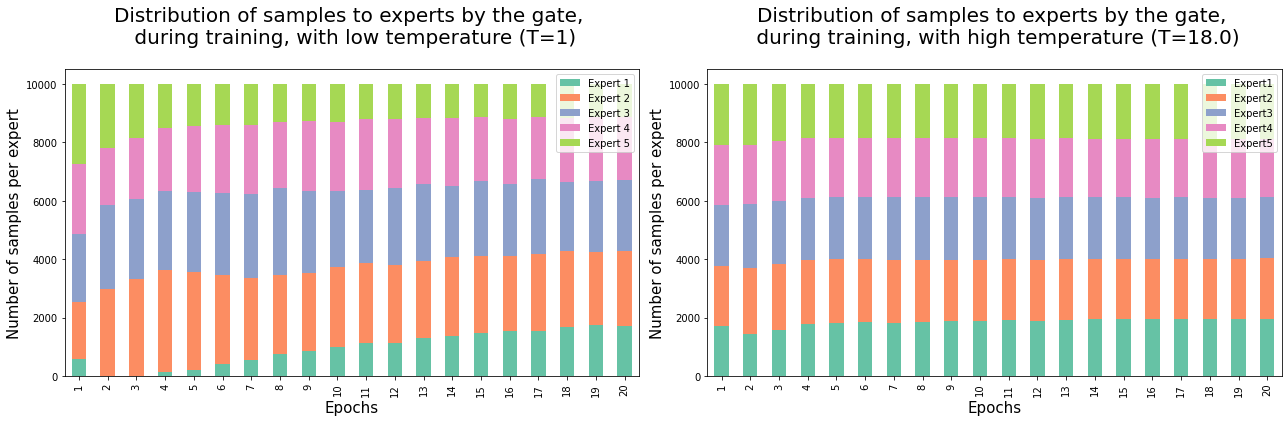

Temperature 20.0
Importance 0.0
Sample sim 0.0


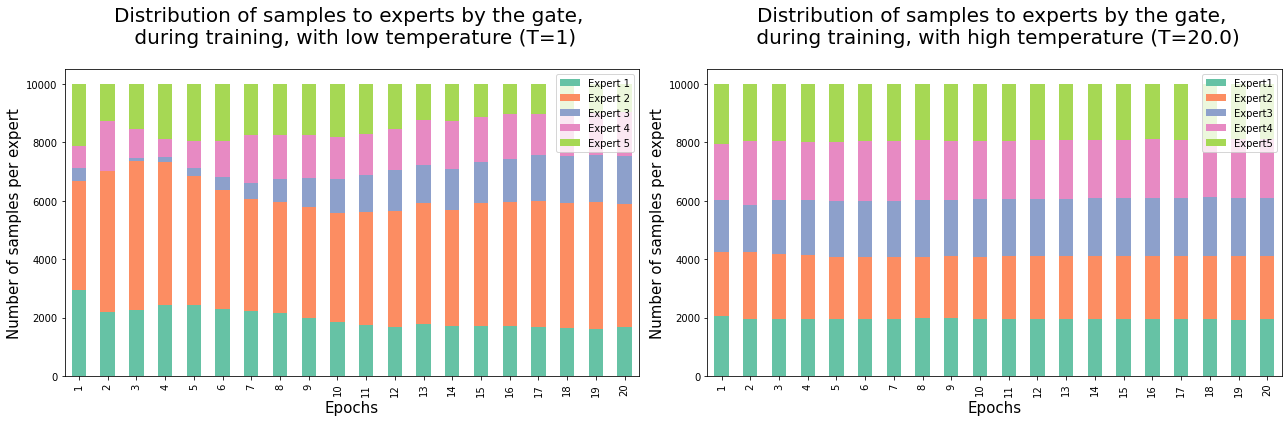

Temperature 25.0
Importance 0.0
Sample sim 0.0


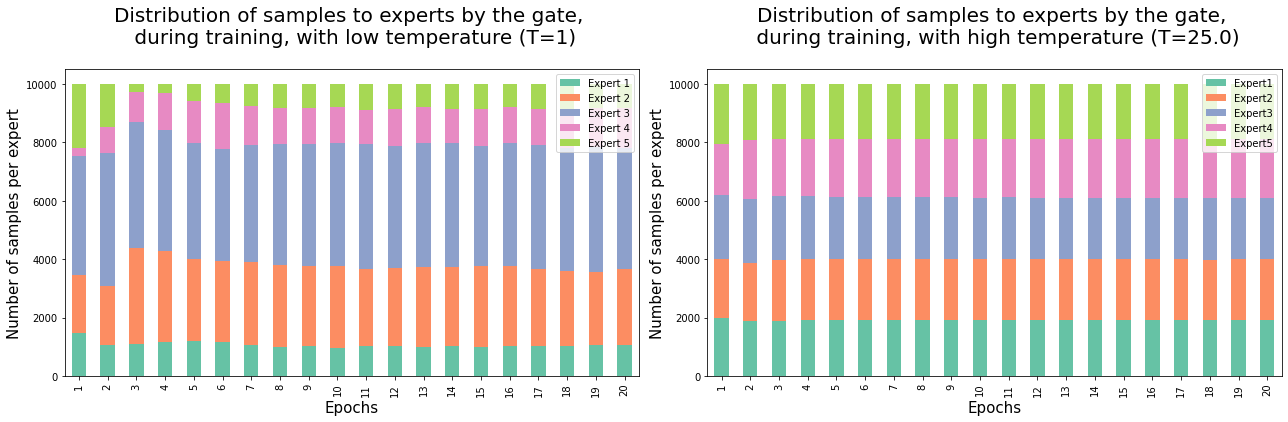

Temperature 30.0
Importance 0.0
Sample sim 0.0


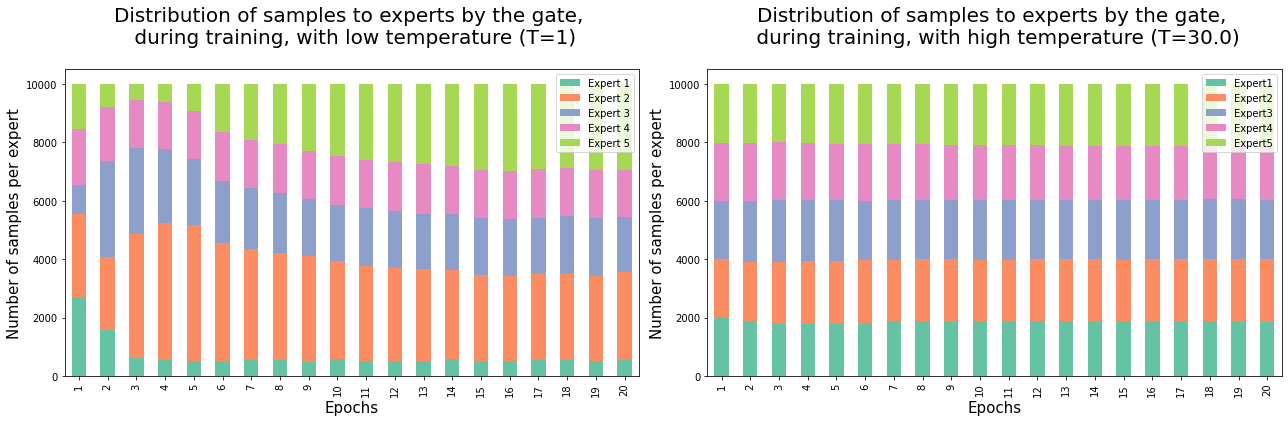

Temperature 35.0
Importance 0.0
Sample sim 0.0


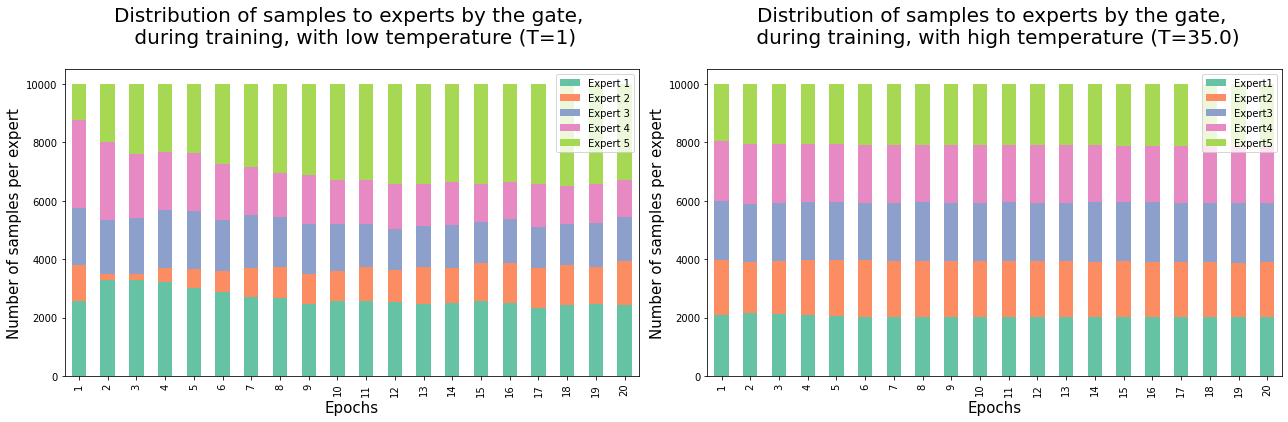

Temperature 40.0
Importance 0.0
Sample sim 0.0


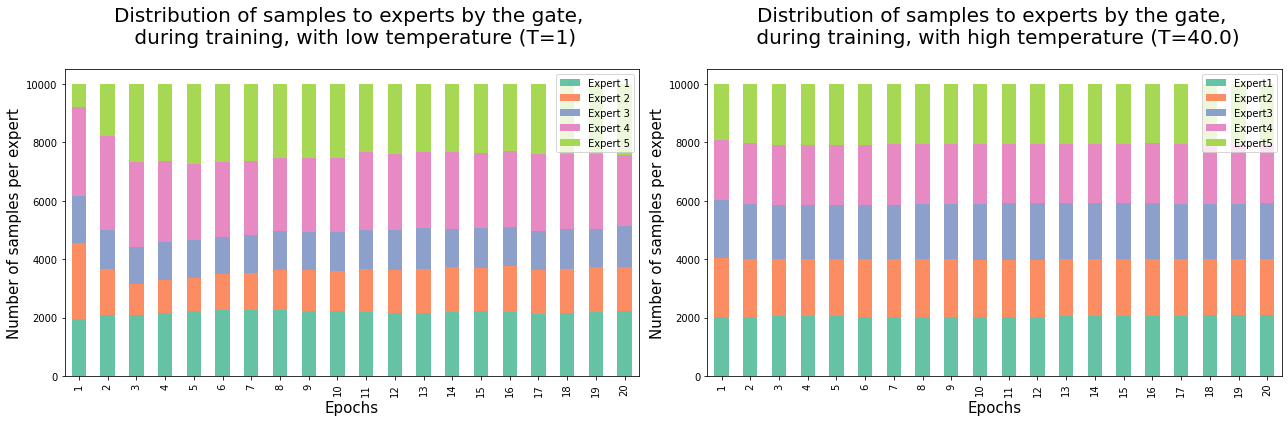

Temperature 45.0
Importance 0.0
Sample sim 0.0


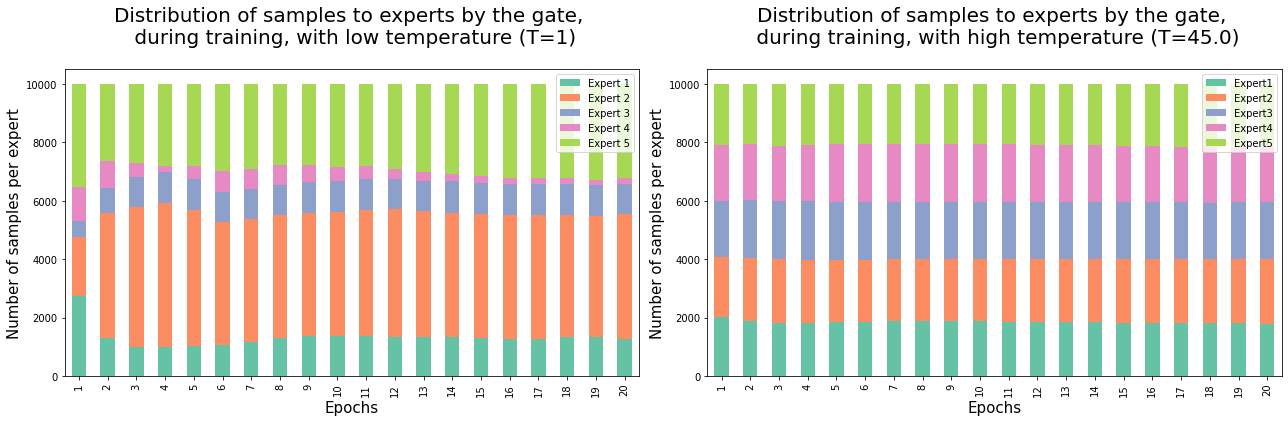

Temperature 50.0
Importance 0.0
Sample sim 0.0


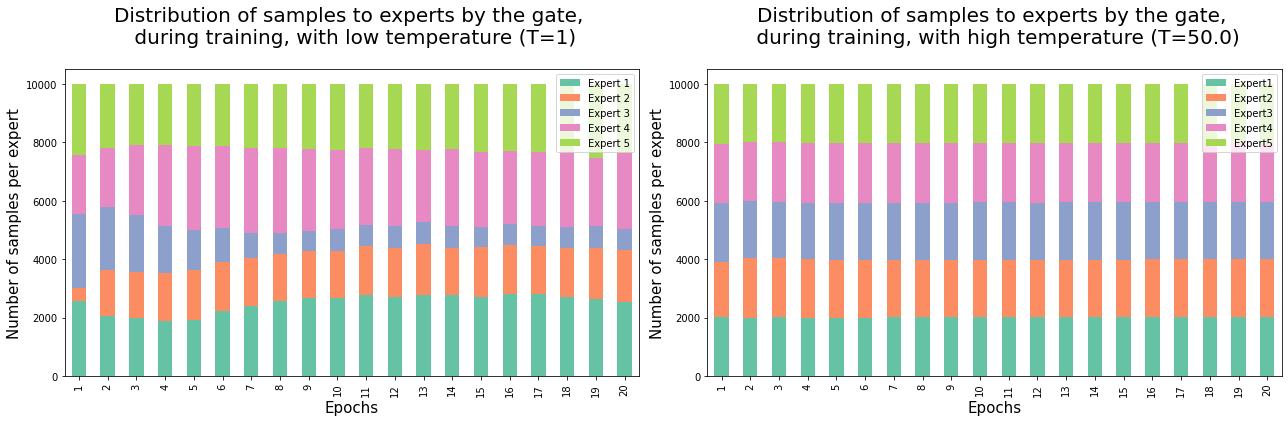

In [93]:
model_with_temp = 'mnist_dual_temp'

total_experts = 5
num_epochs = 20

temps = list(np.arange(1.1,1.6,0.1))+ list(np.arange(2,21,2))+list(np.arange(25,51,5))
print(temps)

caption = 'Distribution of samples to experts by the gate, \n during training, with low temperature (T=1)\n'

plot_gate_prob(model_with_temp, temps, total_experts=total_experts, num_classes=num_classes, 
               classes=range(num_classes), num_epochs=num_epochs, 
               testloader=testloader, caption=caption, index=5)

[20]
Temperature 20.0
Importance 0.0
Sample sim 0.0


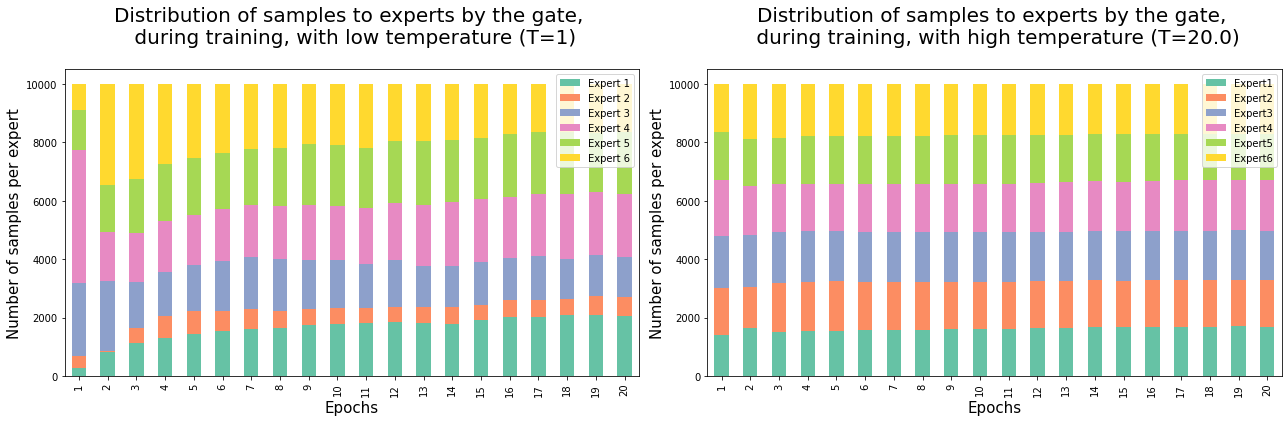

In [116]:
model_with_temp = 'fmnist_mnist_dual_temp'

total_experts = 6
num_epochs = 20

temps = list(np.arange(1.1,1.6,0.1))+ list(np.arange(2,21,2))+list(np.arange(25,51,5))
temps = [20]
print(temps)

caption = 'Distribution of samples to experts by the gate, \n during training, with low temperature (T=1)\n'

plot_gate_prob(model_with_temp, temps, total_experts=total_experts, num_classes=num_classes_fmnist_mnist, 
               classes=range(num_classes), num_epochs=num_epochs, 
               testloader=testloader, caption=caption, index=0)

Temperature 1.0
Importance 0.0
Sample sim 0.0


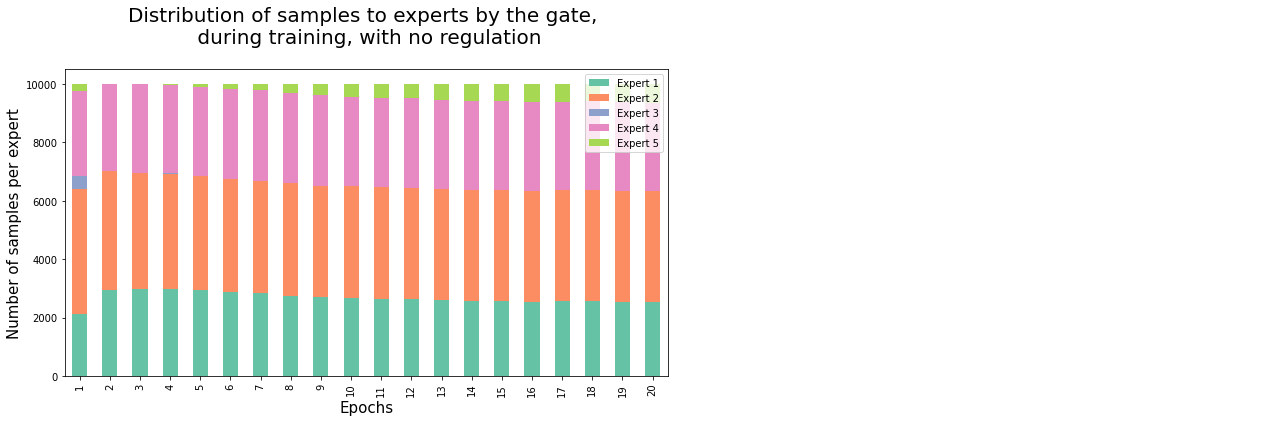

In [62]:
model_without_reg = 'mnist_without_reg_test'

total_experts = 5
num_epochs = 20

caption = 'Distribution of samples to experts by the gate, \n during training, with no regulation\n'

plot_gate_prob(model_without_reg, total_experts=total_experts, num_classes=num_classes, 
               classes = range(num_classes), num_epochs=num_epochs, testloader=testloader, 
               caption=caption, index=6)


[20.0]
[0.4]
Temperature 20.0
Importance 0.4
Sample sim 0.0


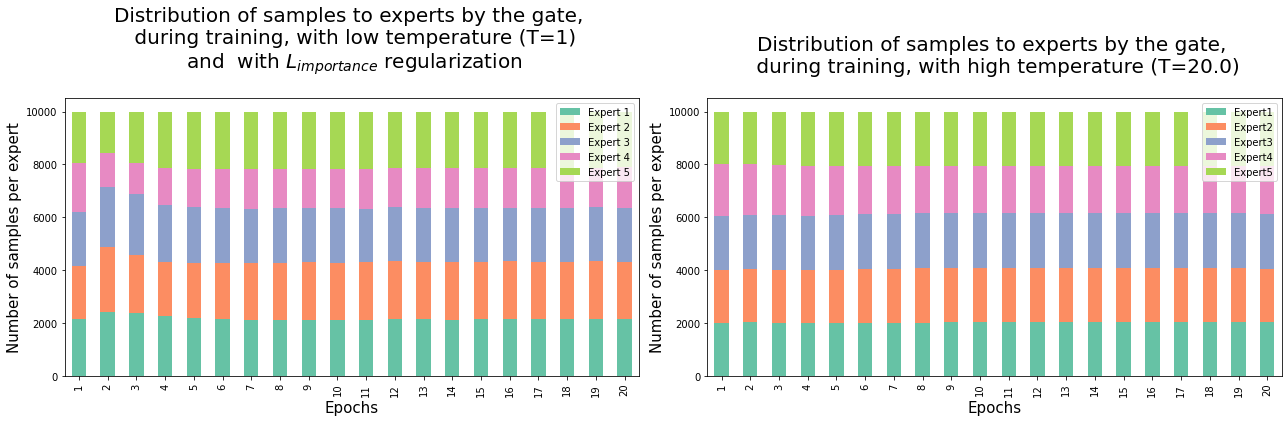

In [74]:
model_with_reg = 'mnist_dual_temp_with_reg_test'
temps = [20.0]
print(temps)
w_importance_range = [0.4]
print(w_importance_range)
caption = 'Distribution of samples to experts by the gate, \n during training, with low temperature (T=1)\n and  with '+r'$L_{importance}$'+ ' regularization \n'
plot_gate_prob(model_with_reg, temps, w_importance_range, total_experts=total_experts, 
               num_classes=num_classes, classes=range(num_classes), num_epochs=num_epochs, 
               testloader=testloader, caption=caption)

[1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000004, 1.5000000000000004, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50]
[0.0]
Temperature 1.1
Importance 0.0
Sample sim 0.0


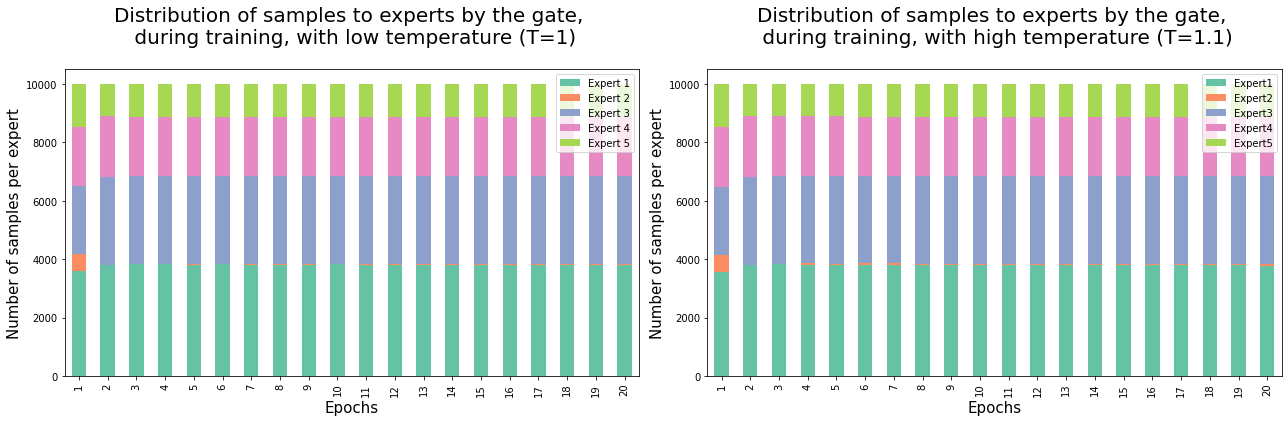

Temperature 1.2
Importance 0.0
Sample sim 0.0


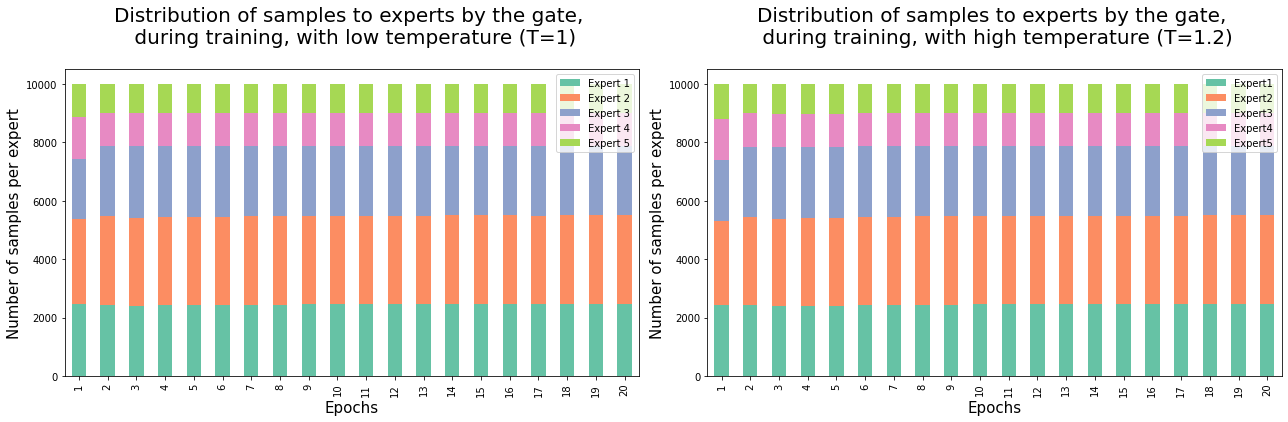

Temperature 1.3
Importance 0.0
Sample sim 0.0


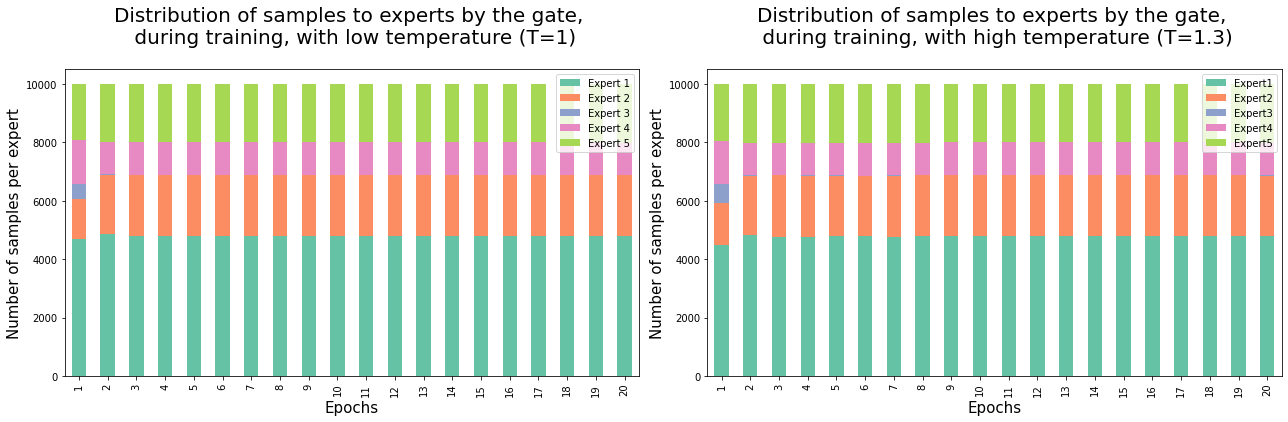

Temperature 1.4
Importance 0.0
Sample sim 0.0


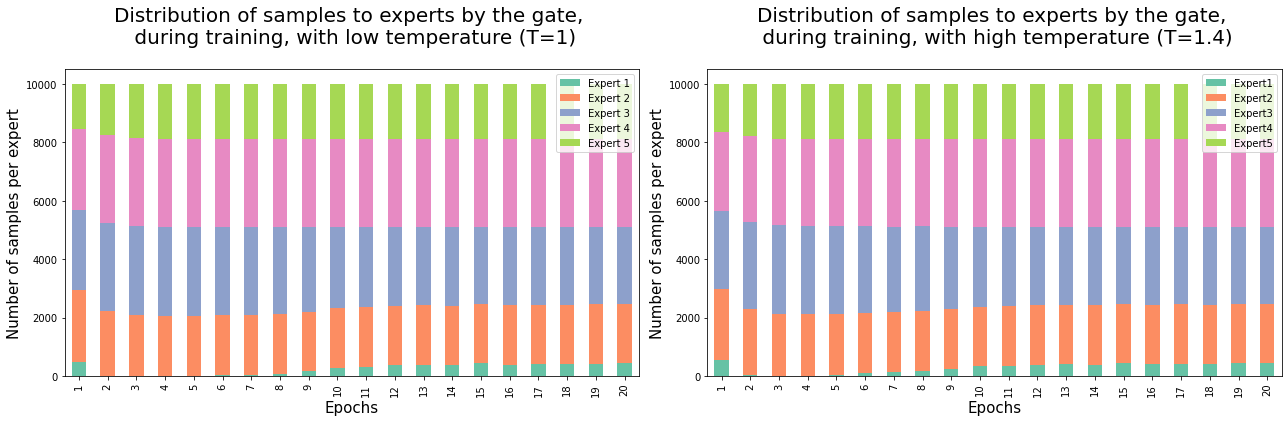

Temperature 1.5
Importance 0.0
Sample sim 0.0


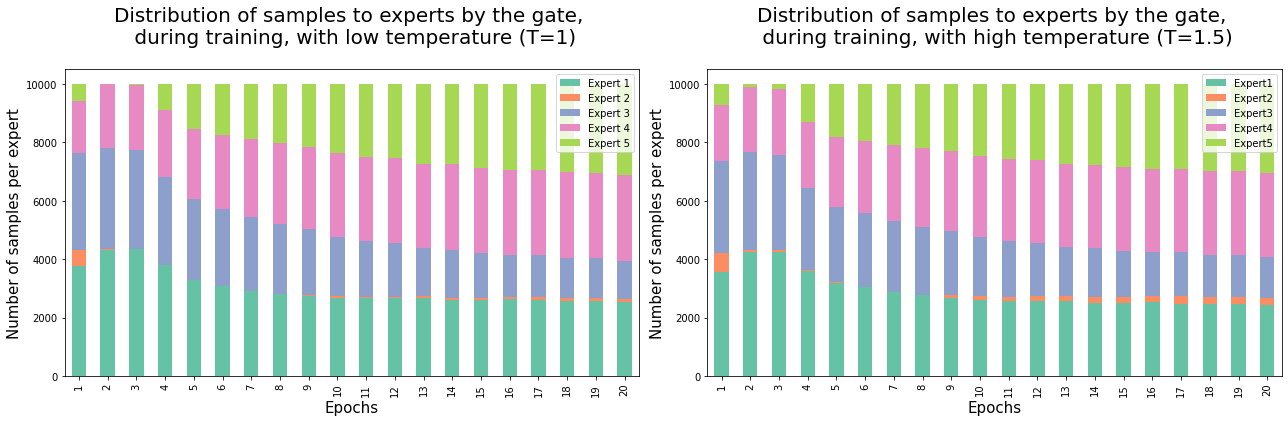

Temperature 2.0
Importance 0.0
Sample sim 0.0


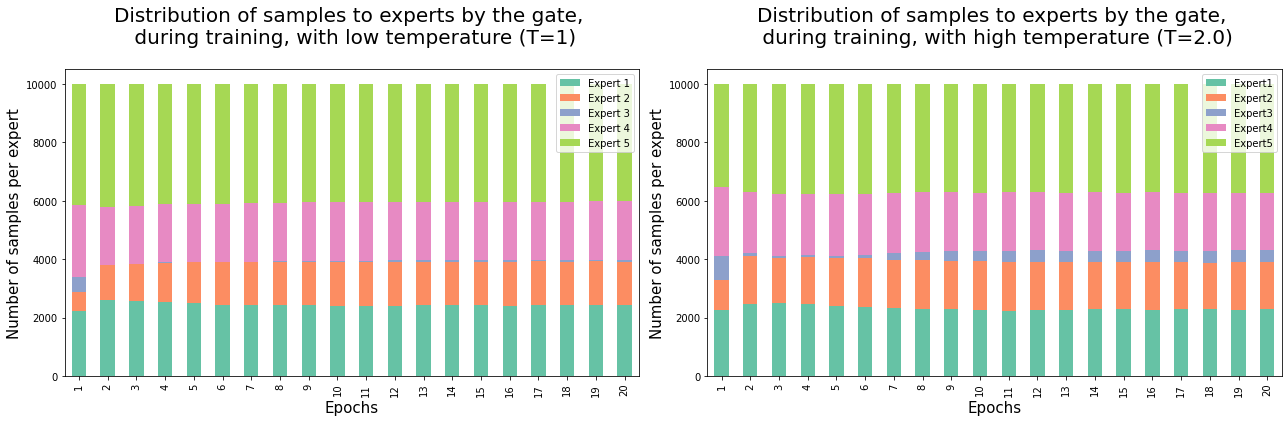

Temperature 4.0
Importance 0.0
Sample sim 0.0


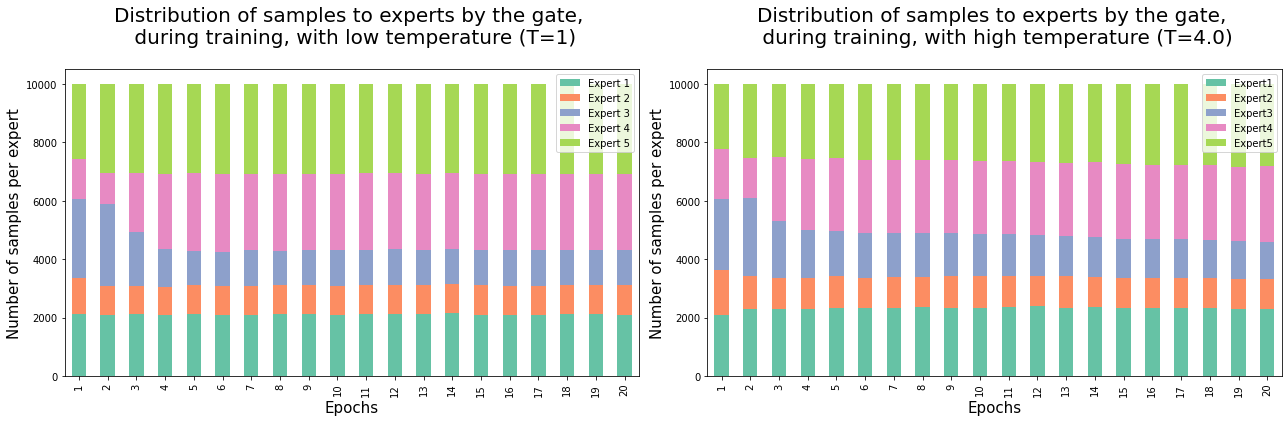

Temperature 6.0
Importance 0.0
Sample sim 0.0


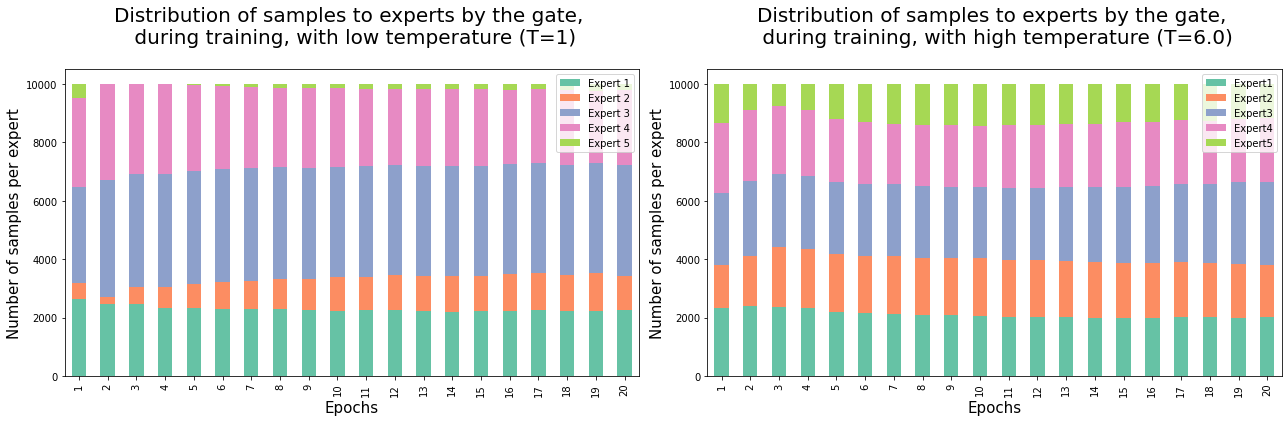

Temperature 8.0
Importance 0.0
Sample sim 0.0


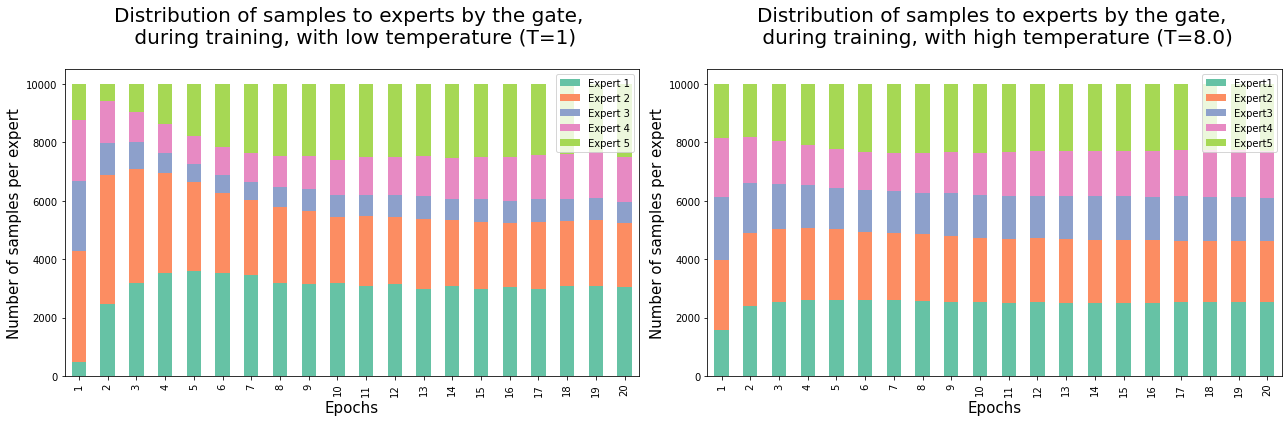

Temperature 10.0
Importance 0.0
Sample sim 0.0


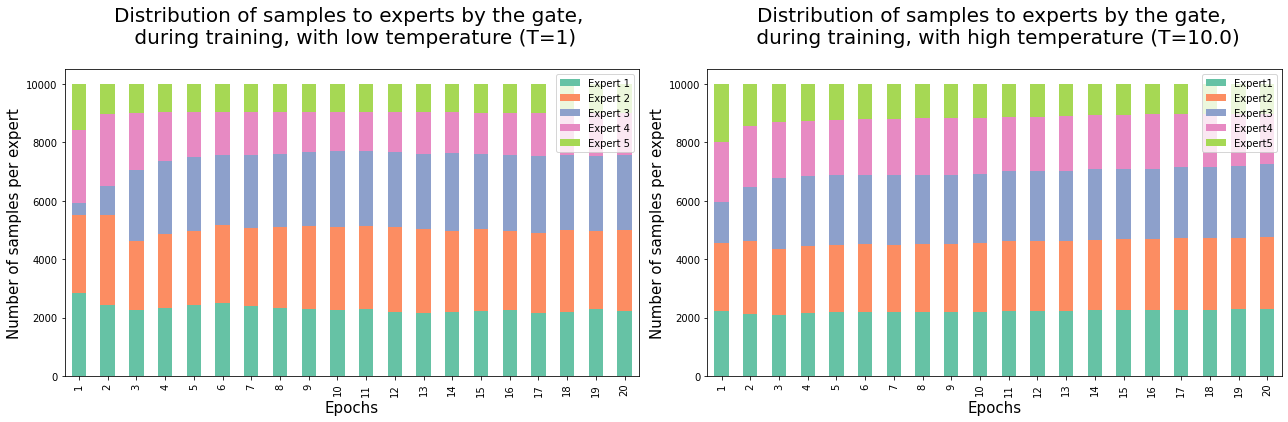

Temperature 12.0
Importance 0.0
Sample sim 0.0


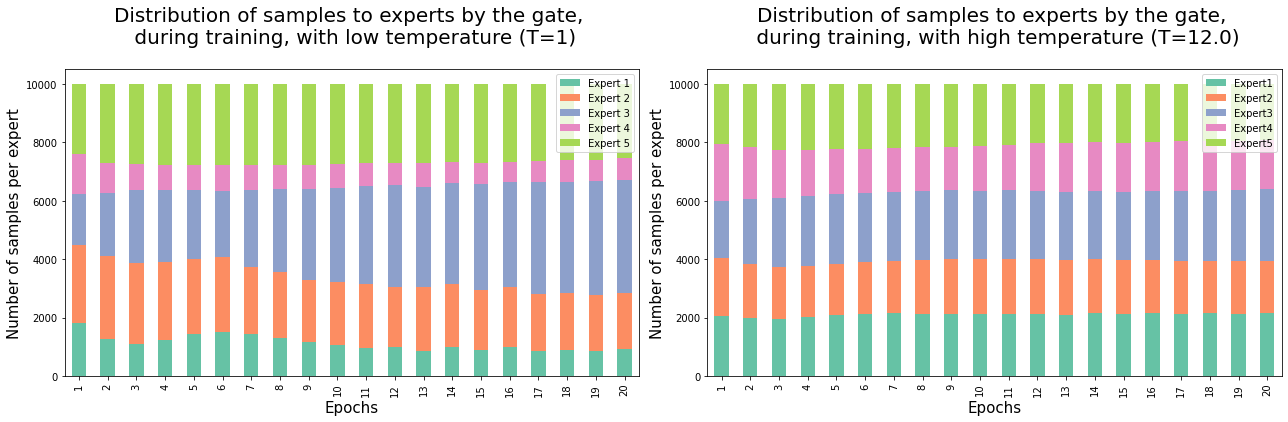

Temperature 14.0
Importance 0.0
Sample sim 0.0


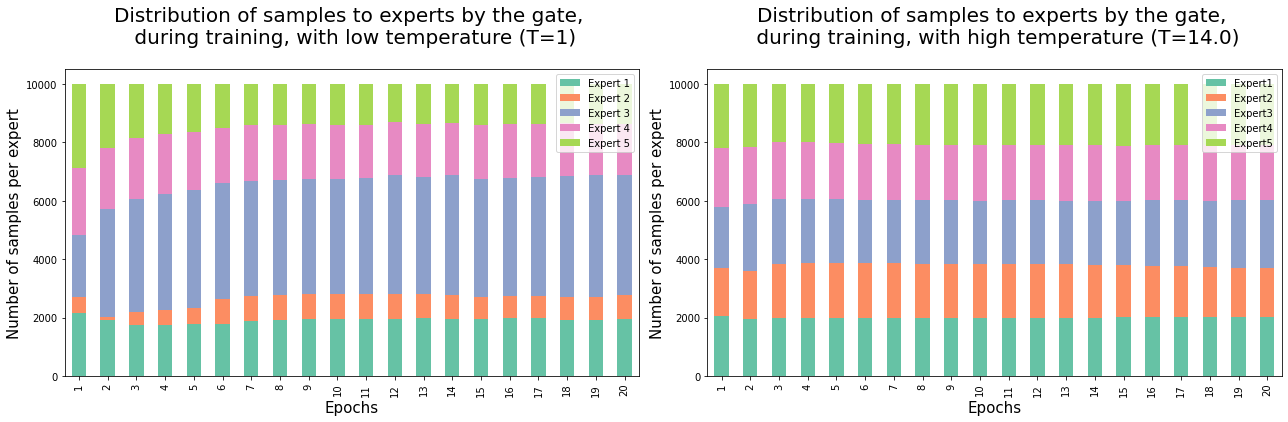

Temperature 16.0
Importance 0.0
Sample sim 0.0


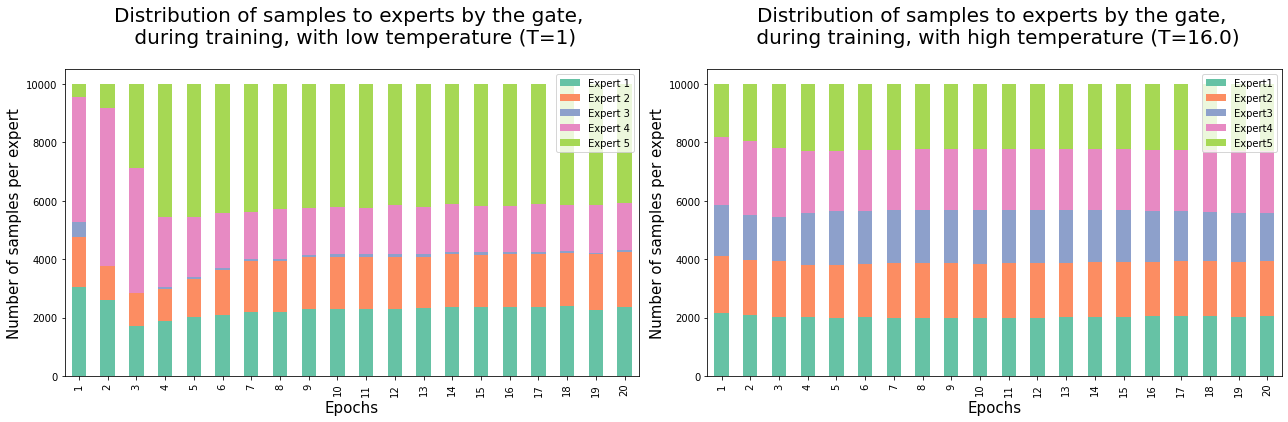

Temperature 18.0
Importance 0.0
Sample sim 0.0


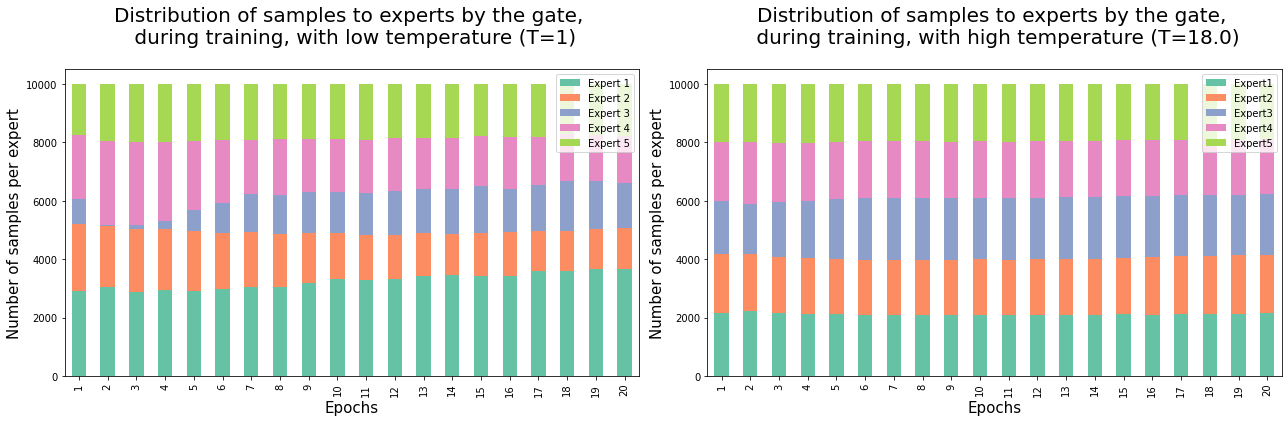

Temperature 20.0
Importance 0.0
Sample sim 0.0


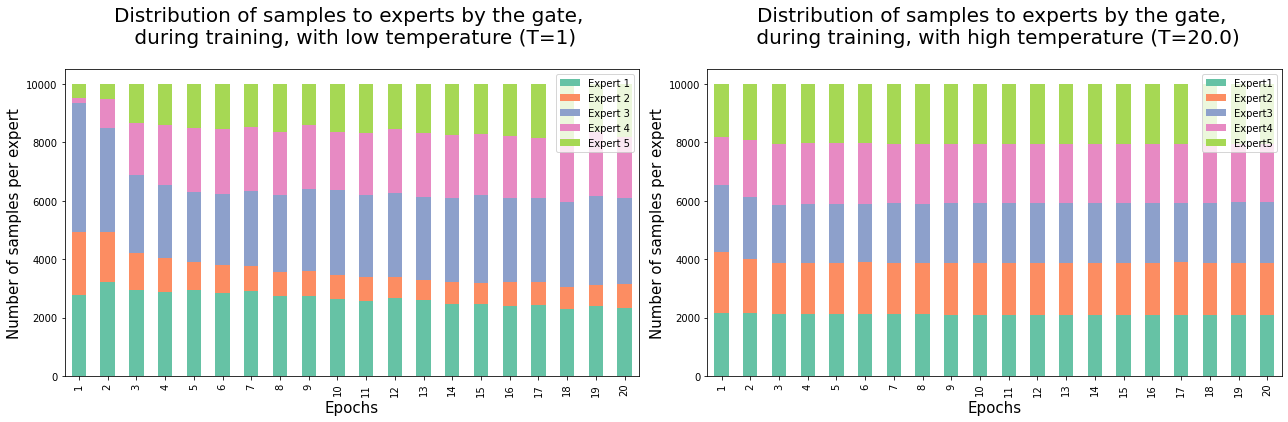

Temperature 25.0
Importance 0.0
Sample sim 0.0


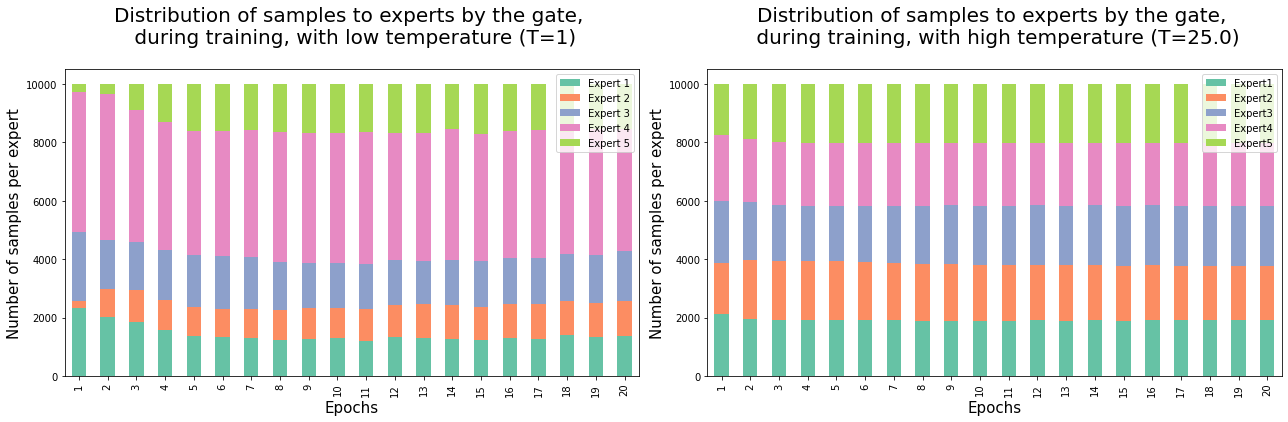

Temperature 30.0
Importance 0.0
Sample sim 0.0


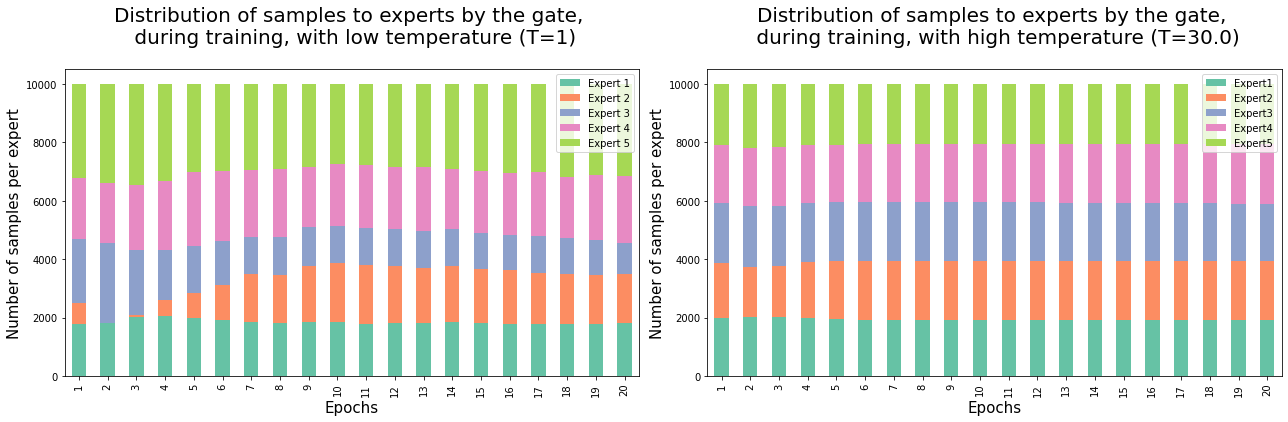

Temperature 35.0
Importance 0.0
Sample sim 0.0


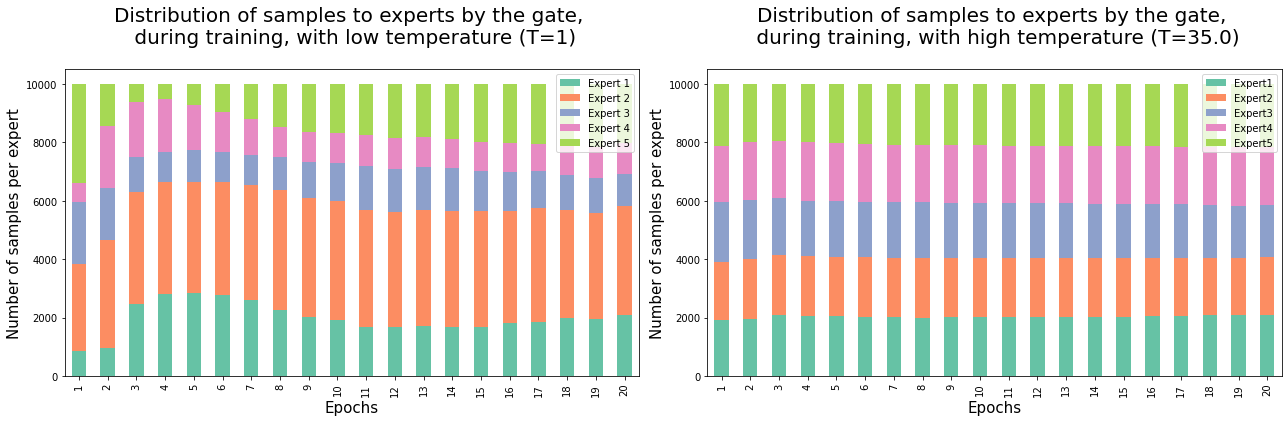

Temperature 40.0
Importance 0.0
Sample sim 0.0


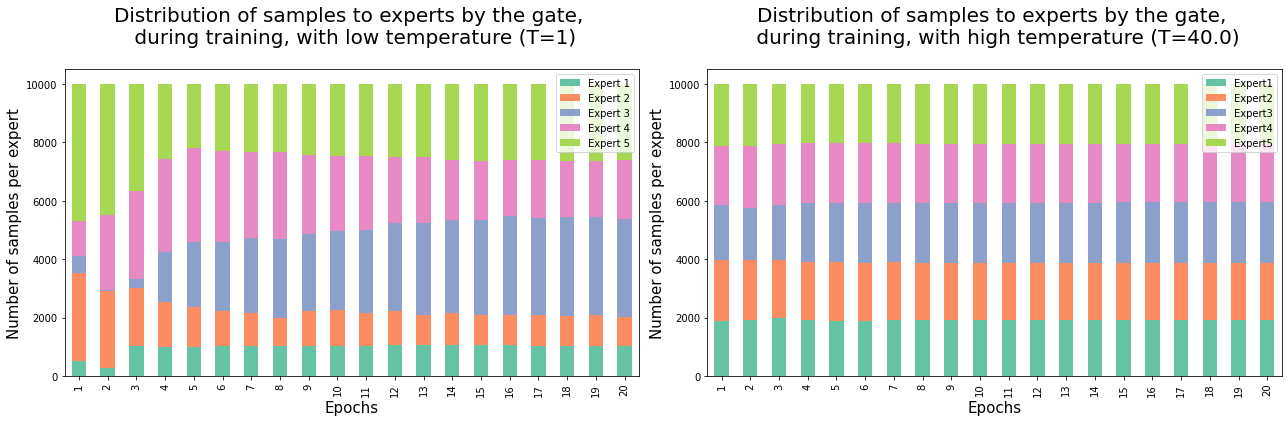

Temperature 45.0
Importance 0.0
Sample sim 0.0


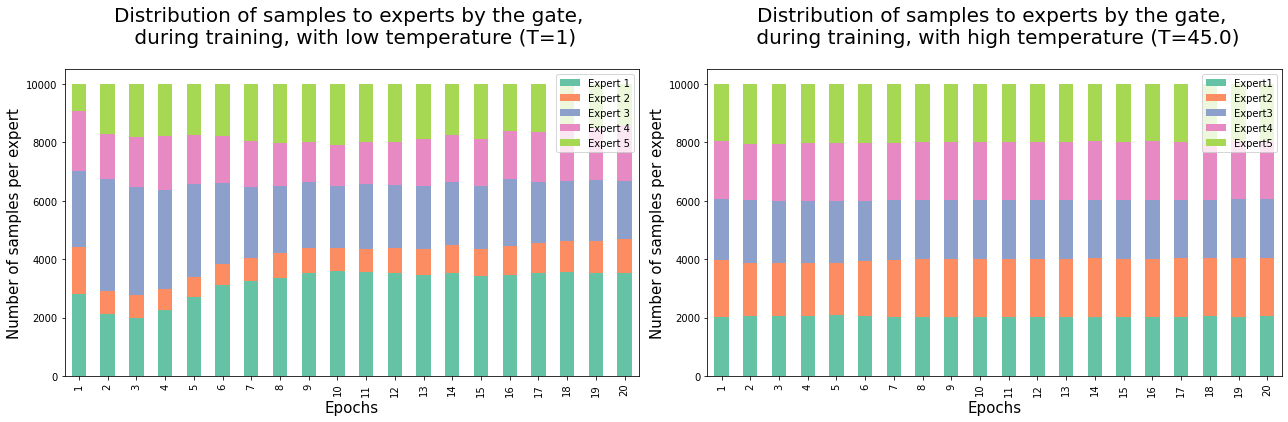

Temperature 50.0
Importance 0.0
Sample sim 0.0


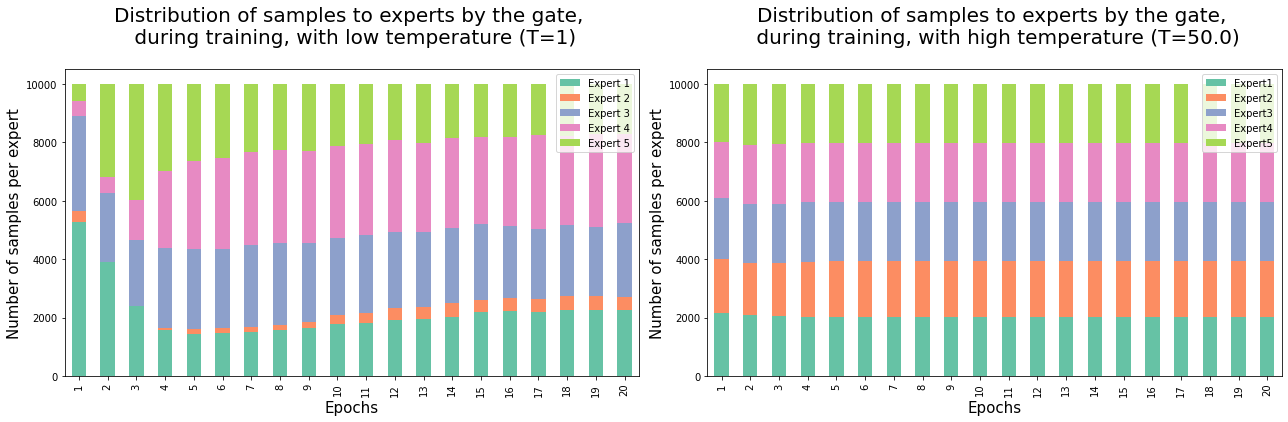

[1.0]
[0.0]
[0.0]
[1.0]
[0.2 0.4 0.6 0.8 1. ]
[0.0]
Temperature 1.0
Importance 0.2
Sample sim 0.0


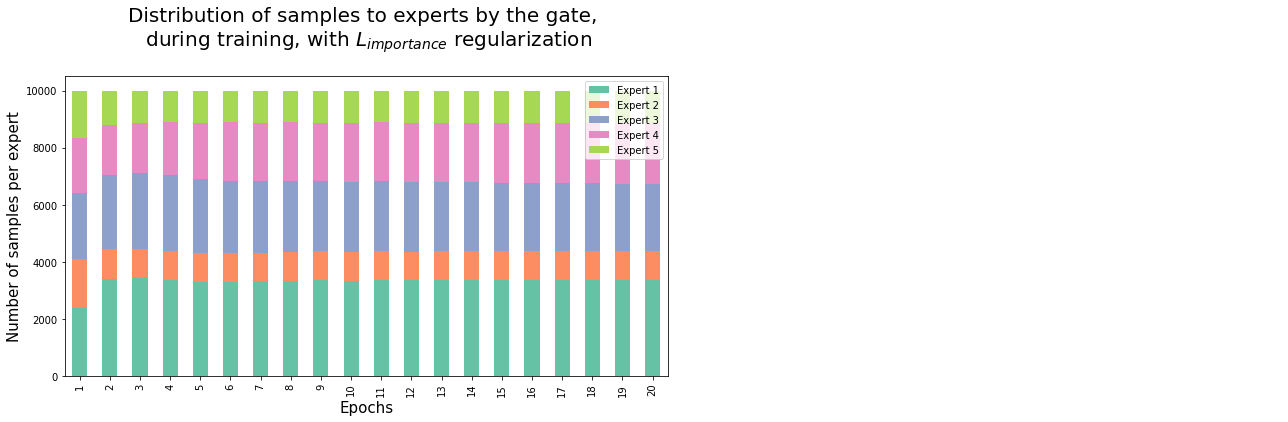

Temperature 1.0
Importance 0.4
Sample sim 0.0


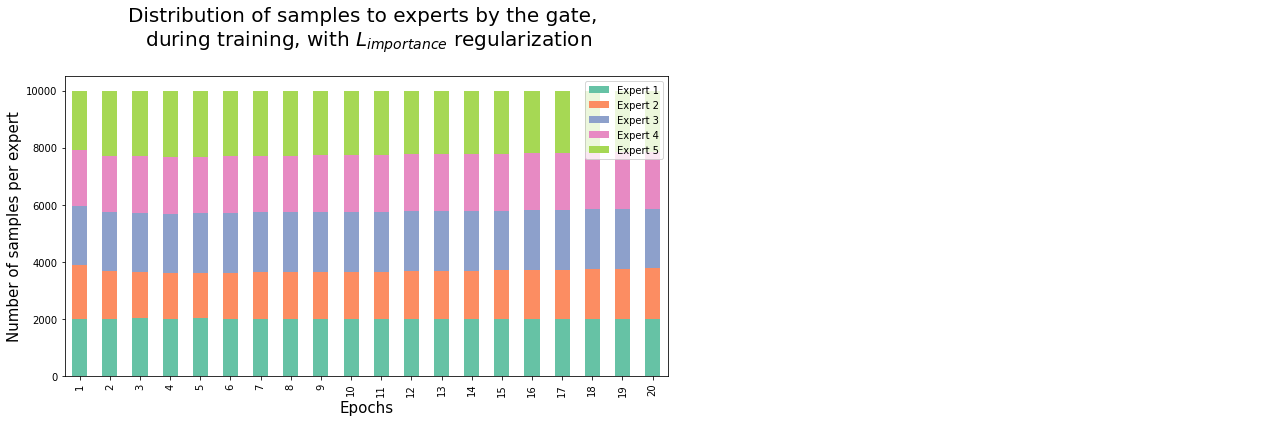

Temperature 1.0
Importance 0.6
Sample sim 0.0


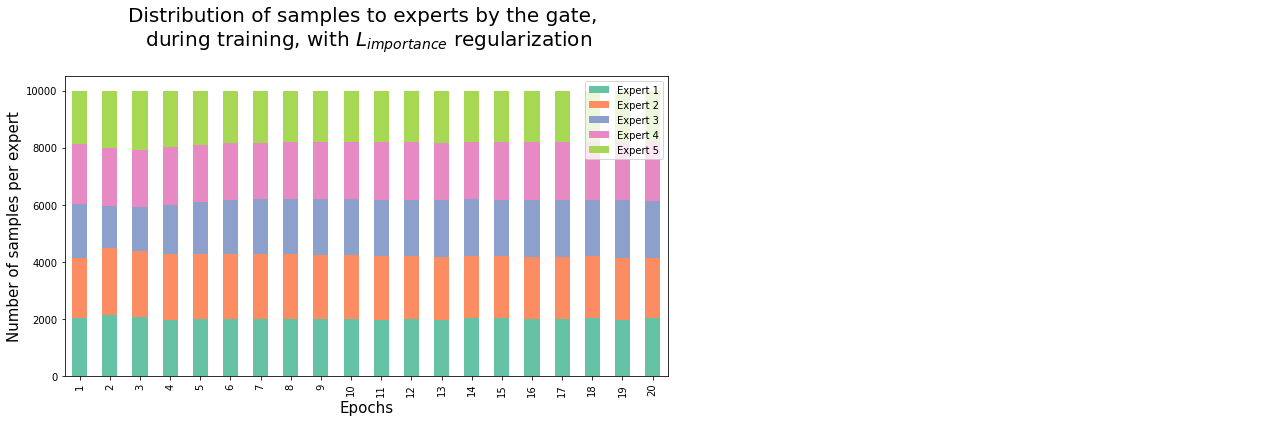

Temperature 1.0
Importance 0.8
Sample sim 0.0


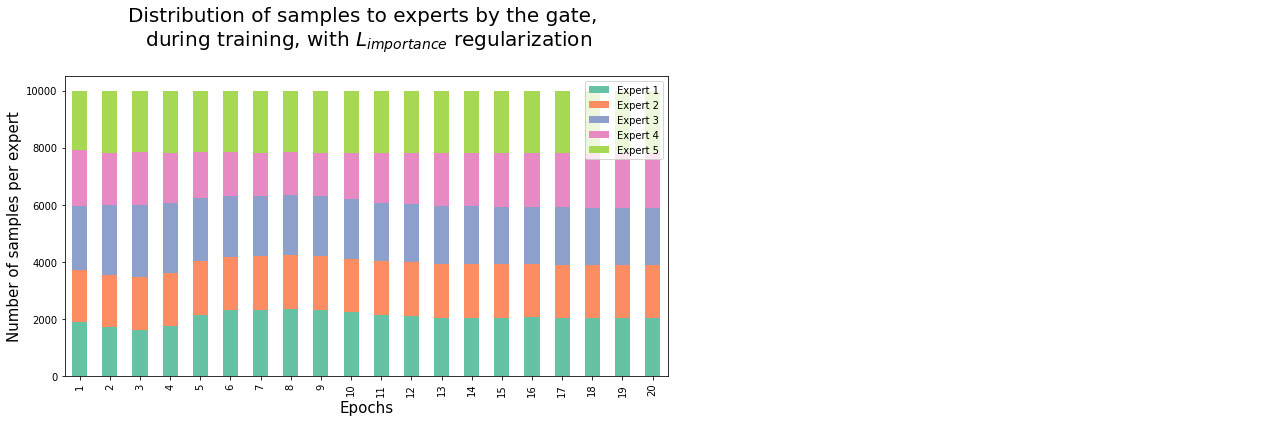

Temperature 1.0
Importance 1.0
Sample sim 0.0


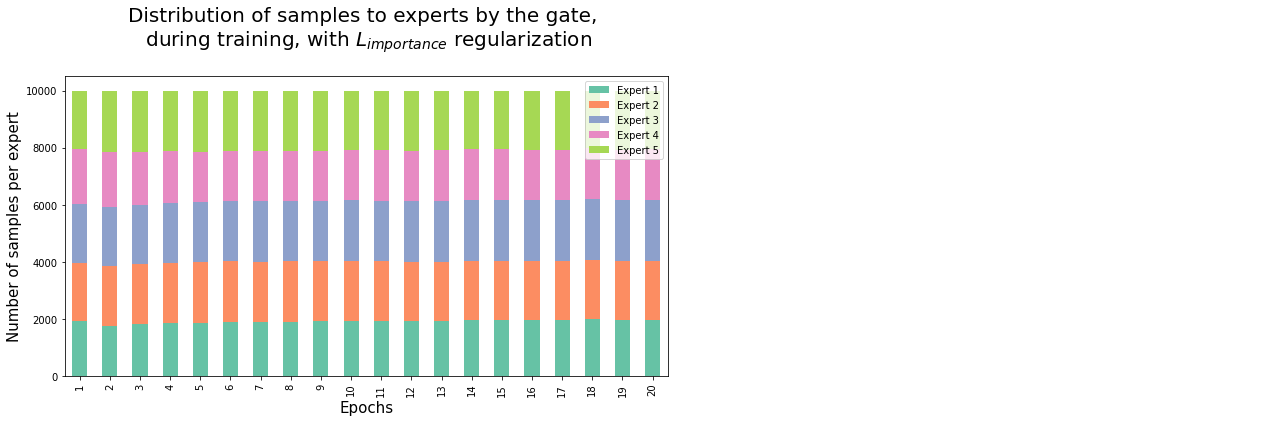

[20.0]
[0.4]
[0.0]
Temperature 20.0
Importance 0.4
Sample sim 0.0


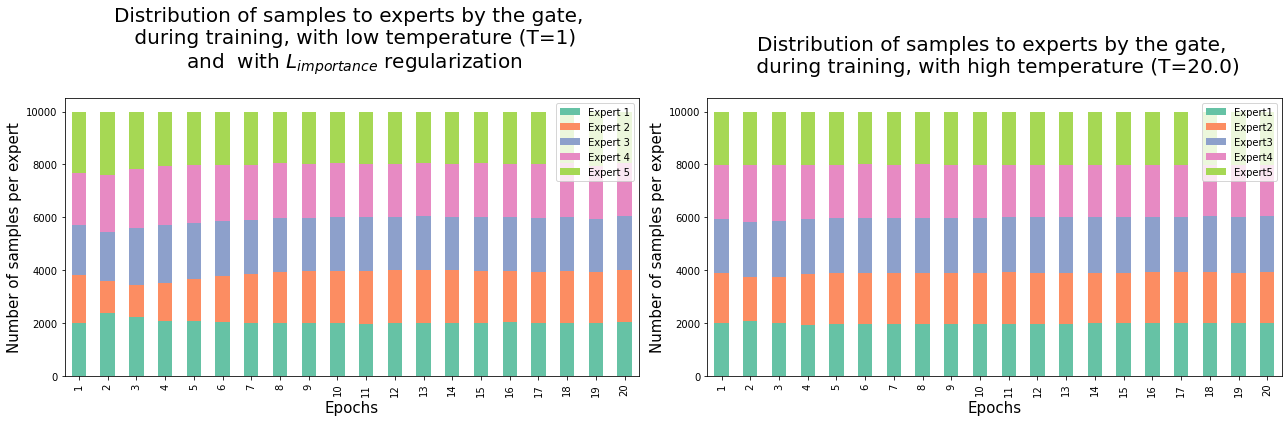

In [98]:
model_with_reg = 'mnist_with_reg_test'
temps = [1.0]
print(temps)
w_importance_range = np.arange(0.2,1.1,0.2)
print(w_importance_range)
w_sample_sim_range = [0.0]
print(w_sample_sim_range)
caption = 'Distribution of samples to experts by the gate, \n during training, with '+r'$L_{importance}$'+ ' regularization \n'
plot_gate_prob(model_with_reg, temps, w_importance_range, w_sample_sim_range, 
               total_experts, num_classes, range(num_classes), num_epochs, 
               testloader, caption)



In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_on_validation'

In [ ]:
num_epochs = 20

In [ ]:
# Set train and test size
trainsize = 2048
testsize = 2000
valsize = 10048

In [ ]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

batch_size = 64
# dataloaders
trainloaders = []
for i in range(total_experts):
    dataset = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(i*trainsize,(i*trainsize)+trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
    trainloaders.append(dataset)
    all_labels = []
    for inputs, labels in dataset:
        all_labels.append(labels)
    all_labels = torch.stack(all_labels)
i+=1
valloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(i*trainsize,(i*trainsize)+valsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(0, valsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(0,testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))
print(len(trainloaders))

In [ ]:
def train_experts(expert_models, trainloaders, accuracy, num_epochs):
    for i, expert in enumerate(expert_models):
        print('Training Expert ', i)
        optimizer_expert = optim.RMSprop(expert.parameters(),
                                      lr=0.001, momentum=0.9)

        loss_criterion = cross_entropy_loss()
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0
            for inputs, labels in trainloaders[i]:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = expert(inputs)

                optimizer_expert.zero_grad()
                loss = loss_criterion(outputs, labels)

                loss.backward()

                optimizer_expert.step()

                running_loss += loss.item()

                outputs = expert(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            print('epoch %d' % epoch,
                  'training loss %.2f' % (running_loss/num_batches),
                   ', training accuracy %.2f' % (train_running_accuracy/num_batches),
                   )

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = model_1
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')
models_list = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print(plot_file)

# columns = ('Expert Epoch', 'Expert Gate', 'CV', 'Accuracy')
# # Add a table at the bottom of the axes
# plt.box(on=None)
# ax = plt.gca()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# the_table = plt.table(cellText=data,
#                       colLabels=columns,
#                      loc='center')
# image_file = generate_plot_file(m, 'cv_accuracy_table_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
# print(image_file)
# plt.savefig(os.path.join(fig_path, image_file))
# plt.show()

# fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
# sns.lineplot(x=cv,y=accuracies, ax=ax)
# plt.show()
                      
for i, models in enumerate(models_list):
    # Plotting for the model of the first run
    print('\nE epoch:', data[i,0], 'G epoch:',data[i,1])
    for e_key, e_val in models.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            # predict the classes for test data
            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs

            # plot the confusion matrix
            print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
            sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
            image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()

            fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

            # get the experts selected by the gate for each sample
            pred_gate_labels = torch.argmax(gate_outputs, dim=1)

            # plot the expert selection table
            print('\nExperts used by the gate for classification of each digit')
            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

            image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig2.savefig(os.path.join(fig_path, image_file))
            plt.show()

In [ ]:
new_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(valsize, 3*valsize)), 
                                          batch_size=2*valsize,
                                          shuffle=True)

In [ ]:
image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))
print(len(new_trainloader.dataset))

In [ ]:
indices = None
for inputs, labels in new_trainloader:
    inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    outputs = sm(inputs)
    indices = torch.where((torch.argmax(outputs, dim=1)==labels)==True)[0]

In [ ]:
new_trainloader_1 = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, (indices+valsize)[0:valsize]), 
                                          batch_size=batch_size,
                                          shuffle=True)
print(len(new_trainloader.dataset))

In [ ]:
model_3 = 'selected_data'

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = model_3
total_experts = 5
plot_file = generate_plot_file(model_3, 'importance_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
                      
# Plotting for the model of the first run
for e_key, e_val in models.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']

        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)
        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # plot the confusion matrix
        print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
        image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()

        fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

        image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig2.savefig(os.path.join(fig_path, image_file))
        plt.show()
        
        misclassified = torch.where((pred_labels == labels)==False)[0]
        for i in range(num_classes):
            indices = labels[misclassified]==i
            print(i,' is misclassified as ', pred_labels[misclassified][indices])
            images_orig = images[misclassified][indices]
            img_grid = torchvision.utils.make_grid(images_orig)
            # show images
            imshow(img_grid, one_channel=True)
